# Fallstudie SCM - Flottenoptimierung (Einzelfahrzeug-Ebene)

## Version 2.3 (Gurobi): KORRIGIERTES Modell mit NB21/NB24/NB27

### Korrekturen in Version 2.3 (Gurobi):
- **HiGHS Solver** statt CBC (schneller, bessere Heuristiken)
- **2 Stunden Zeitlimit** statt 30 Minuten
- **Speicher-OPEX (2%)** korrekt in Zielfunktion integriert
- **Exklusiver Speicher-Modus** verhindert gleichzeitiges Laden und Entladen

Dieses Notebook implementiert das Optimierungsmodell auf **Einzelfahrzeug-Ebene** statt auf Fahrzeugtyp-Ebene.

### Hauptunterschiede zu Version 1 (Fahrzeugtyp-Ebene):
- **V = {v1, v2, ..., v20}** statt F = {ActrosL, eActros400, eActros600}
- **is_type[v,f]** entscheidet welchen Typ jedes Fahrzeug hat
- **soc[v,t]** trackt SOC pro Einzelfahrzeug (nicht pro Typ-Pool)
- Direkte Fahrzeug-Routen-Zuweisungen ohne Heuristik
- **NB0**: Periodizität (SOC[1] = SOC[96]) - implizit
- **NB13**: Ladeverluste η=0.95 (5% Verluste)
- **NB21 NEU**: Ladeunterbrechungsverbot (χ[t] - χ[t+1] ≤ ω[t+1])
- **NB24a/b**: Vollladen-Schutz mit μ-Variable
- **NB27**: Zwangsfreigabe tagsüber
- **NB_STAY**: Mitternachts-Lücke geschlossen
- **T_day**: Neue Indexmenge für 06:00-18:00



## 1. Imports und Setup

In [1]:

# ============================================================================
# INSTALLATION (lokal mit Gurobi)
# ============================================================================

!pip install "pulp>=2.7" gurobipy -q

print("✓ Gurobi bereit!")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip
✓ Gurobi bereit!


In [2]:
# Imports
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Visualisierungs-Einstellungen
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Solver-Check
print("Verfuegbare Solver:", listSolvers(onlyAvailable=True))

Verfuegbare Solver: ['GUROBI', 'PULP_CBC_CMD']


## 2. Parameter und Daten

In [3]:
# ============================================================================
# ZEITPARAMETER
# ============================================================================
T = list(range(1, 97))  # 96 Zeitschritte (15-Min-Intervalle, 00:00-24:00)
delta_t = 0.25  # Stunden pro Zeitschritt
days = 260  # Betriebstage pro Jahr

# Nachtzeit: 18:00-06:00 (Zeitschritte 73-96 und 1-24)
T_night = list(range(73, 97)) + list(range(1, 25))

# [NEU] Tagzeit: 06:00-18:00 (Zeitschritte 25-72)
T_day = list(range(25, 73))

# [NEU] Ladewirkungsgrad (5% Verluste)
eta_charging = 0.95

def time_to_index(time_str):
    """Konvertiert Zeitstring 'HH:MM' in Zeitindex (1-96)"""
    h, m = map(int, time_str.split(':'))
    return (h * 4) + (m // 15) + 1

def index_to_time(idx):
    """Konvertiert Zeitindex in Zeitstring"""
    minutes = (idx - 1) * 15
    return f"{minutes // 60:02d}:{minutes % 60:02d}"

print(f"Zeitschritte: {len(T)} (je {delta_t*60:.0f} Minuten)")
print(f"Nachtzeit-Schritte (T_night): {len(T_night)} (18:00-06:00)")
print(f"Tagzeit-Schritte (T_day): {len(T_day)} (06:00-18:00)")
print(f"Ladewirkungsgrad: η = {eta_charging} (5% Verluste)")

Zeitschritte: 96 (je 15 Minuten)
Nachtzeit-Schritte (T_night): 48 (18:00-06:00)
Tagzeit-Schritte (T_day): 48 (06:00-18:00)
Ladewirkungsgrad: η = 0.95 (5% Verluste)


In [4]:
# ============================================================================
# FAHRZEUGFLOTTE
# ============================================================================

# Fahrzeugtypen (bleiben erhalten fuer Typzuordnung)
F = ['ActrosL', 'eActros400', 'eActros600']
F_d = ['ActrosL']  # Diesel
F_e = ['eActros400', 'eActros600']  # Elektro

# [NEU] Fahrzeugpool - max. 20 Fahrzeuge
V = [f"v{i}" for i in range(1, 21)]
print(f"Fahrzeugpool V: {len(V)} Fahrzeuge ({V[0]} bis {V[-1]})")

# Fahrzeugparameter pro Typ
capex_f = {'ActrosL': 24000, 'eActros400': 50000, 'eActros600': 60000}
opex_f = {'ActrosL': 6000, 'eActros400': 5000, 'eActros600': 6000}
consumption_f = {'ActrosL': 26, 'eActros400': 105, 'eActros600': 110}  # L/100km bzw kWh/100km
kfz_tax_f = {'ActrosL': 556, 'eActros400': 0, 'eActros600': 0}
thg_f = {'ActrosL': 0, 'eActros400': 1000, 'eActros600': 1000}  # THG-Quote Erloes
battery_cap_f = {'ActrosL': 0, 'eActros400': 414, 'eActros600': 621}
max_charge_f = {'ActrosL': 0, 'eActros400': 400, 'eActros600': 400}
soc_min_f = {'ActrosL': 0, 'eActros400': 41.4, 'eActros600': 62.1}  # 10% Mindest-SOC

print("\nFahrzeugtypen:")
print(f"  Diesel: {F_d}")
print(f"  Elektro: {F_e}")
print(f"\nBatteriekapazitaeten: eActros400={battery_cap_f['eActros400']} kWh, eActros600={battery_cap_f['eActros600']} kWh")

Fahrzeugpool V: 20 Fahrzeuge (v1 bis v20)

Fahrzeugtypen:
  Diesel: ['ActrosL']
  Elektro: ['eActros400', 'eActros600']

Batteriekapazitaeten: eActros400=414 kWh, eActros600=621 kWh


In [5]:
# ============================================================================
# ROUTEN
# ============================================================================

# Routen-Daten
routes_data = {
    't-4': {'name': 'Nahverkehr', 'dist': 250, 'dist_toll': 150, 'start': '06:45', 'end': '17:15'},
    't-5': {'name': 'Nahverkehr', 'dist': 250, 'dist_toll': 150, 'start': '06:30', 'end': '17:00'},
    't-6': {'name': 'Nahverkehr', 'dist': 250, 'dist_toll': 150, 'start': '06:00', 'end': '16:30'},
    's-1': {'name': 'Ditzingen', 'dist': 120, 'dist_toll': 32, 'start': '05:30', 'end': '15:30'},
    's-2': {'name': 'Ditzingen', 'dist': 120, 'dist_toll': 32, 'start': '06:00', 'end': '16:00'},
    's-3': {'name': 'Ditzingen', 'dist': 120, 'dist_toll': 32, 'start': '09:00', 'end': '16:00'},
    's-4': {'name': 'Ditzingen', 'dist': 120, 'dist_toll': 32, 'start': '06:30', 'end': '16:30'},
    'w1': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '05:30', 'end': '15:30'},
    'w2': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '08:00', 'end': '18:00'},
    'w3': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '06:45', 'end': '16:45'},
    'w4': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '06:00', 'end': '16:00'},
    'w5': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '07:00', 'end': '17:00'},
    'w6': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '05:30', 'end': '15:30'},
    'w7': {'name': 'Ditzingen', 'dist': 100, 'dist_toll': 32, 'start': '07:15', 'end': '17:15'},
    'r1': {'name': 'MultiStop', 'dist': 285, 'dist_toll': 259, 'start': '18:00', 'end': '22:30'},
    'r2': {'name': 'MultiStop', 'dist': 250, 'dist_toll': 220, 'start': '16:30', 'end': '21:45'},
    'r3': {'name': 'Schramberg', 'dist': 235, 'dist_toll': 219, 'start': '17:45', 'end': '21:30'},
    'h3': {'name': 'Hettingen', 'dist': 180, 'dist_toll': 160, 'start': '18:45', 'end': '22:45'},
    'h4': {'name': 'Hettingen', 'dist': 180, 'dist_toll': 160, 'start': '18:30', 'end': '22:30'},
    'k1': {'name': 'Wendlingen', 'dist': 275, 'dist_toll': 235, 'start': '16:30', 'end': '22:30'},
}

R = list(routes_data.keys())
dist_r = {r: routes_data[r]['dist'] for r in R}
dist_toll_r = {r: routes_data[r]['dist_toll'] for r in R}
start_r = {r: time_to_index(routes_data[r]['start']) for r in R}
end_r = {r: time_to_index(routes_data[r]['end']) for r in R}

print(f"Anzahl Routen: {len(R)}")
print(f"Gesamtdistanz pro Tag: {sum(dist_r.values())} km")

Anzahl Routen: 20
Gesamtdistanz pro Tag: 3335 km


In [6]:
# ============================================================================
# LADEINFRASTRUKTUR
# ============================================================================

L = ['Alpitronic-50', 'Alpitronic-200', 'Alpitronic-400']
capex_l = {'Alpitronic-50': 3000, 'Alpitronic-200': 10000, 'Alpitronic-400': 16000}
opex_l = {'Alpitronic-50': 1000, 'Alpitronic-200': 1500, 'Alpitronic-400': 2000}
max_power_l = {'Alpitronic-50': 50, 'Alpitronic-200': 200, 'Alpitronic-400': 400}

# Ladepunkte pro Saeule (aus chargers.csv - FEST!)
spots_l = {'Alpitronic-50': 2, 'Alpitronic-200': 2, 'Alpitronic-400': 2}

max_chargers = 3  # Max. 3 Ladesaeulen installierbar

print("Ladesaeulen:")
for l in L:
    print(f"  {l}: {max_power_l[l]} kW, {spots_l[l]} Ladepunkte, {capex_l[l]} EUR/Jahr")
print(f"\nMax. Ladepunkte gesamt: {sum(spots_l.values())} (bei allen 3 Saeulen)")

Ladesaeulen:
  Alpitronic-50: 50 kW, 2 Ladepunkte, 3000 EUR/Jahr
  Alpitronic-200: 200 kW, 2 Ladepunkte, 10000 EUR/Jahr
  Alpitronic-400: 400 kW, 2 Ladepunkte, 16000 EUR/Jahr

Max. Ladepunkte gesamt: 6 (bei allen 3 Saeulen)


In [7]:
# ============================================================================
# ENERGIEKOSTEN & WEITERE PARAMETER
# ============================================================================

# Stromkosten
price_energy = 0.25  # EUR/kWh
price_power = 150    # EUR/kW (Leistungspreis)
price_base = 1000    # EUR/Jahr (Grundgebuehr)

# Netzanschluss
P_grid_max_base = 500  # kW Basis-Netzanschluss
P_grid_extension = 500  # kW Erweiterung
price_grid_extension = 10000  # EUR/Jahr

# Diesel & Maut
price_diesel = 1.60  # EUR/L
price_toll = 0.34    # EUR/km (nur Diesel auf Mautstrassen)

# Batteriespeicher (laut Fallstudie: CAPEX + 2% OPEX)
price_storage_power = 30   # EUR/kW p.a. (CAPEX)
price_storage_cap = 350    # EUR/kWh p.a. (CAPEX)
storage_opex_rate = 0.02   # 2% OPEX der Gesamtinvestition
storage_efficiency = 0.98  # Round-trip (98%)
storage_dod = 0.975        # Max Entladetiefe (97.5%)

print("Energiekosten:")
print(f"  Arbeitspreis: {price_energy} EUR/kWh")
print(f"  Leistungspreis: {price_power} EUR/kW")
print(f"  Dieselpreis: {price_diesel} EUR/L")
print(f"  Maut (Diesel): {price_toll} EUR/km")

Energiekosten:
  Arbeitspreis: 0.25 EUR/kWh
  Leistungspreis: 150 EUR/kW
  Dieselpreis: 1.6 EUR/L
  Maut (Diesel): 0.34 EUR/km


## 3. Modell erstellen

In [8]:
# ============================================================================
# MILP MODELL - EINZELFAHRZEUG-EBENE
# ============================================================================

model = LpProblem("Flottenoptimierung_Einzelfahrzeug", LpMinimize)
print("Modell erstellt: Flottenoptimierung auf Einzelfahrzeug-Ebene")

Modell erstellt: Flottenoptimierung auf Einzelfahrzeug-Ebene


## 4. Entscheidungsvariablen

In [9]:
# ============================================================================
# [NEU] ENTSCHEIDUNGSVARIABLEN - EINZELFAHRZEUG-EBENE
# ============================================================================

# Fahrzeugvariablen
use = LpVariable.dicts("use", V, cat='Binary')  # Fahrzeug v wird eingesetzt
is_type = LpVariable.dicts("is_type", [(v, f) for v in V for f in F], cat='Binary')  # Fahrzeug v ist Typ f
is_electric = LpVariable.dicts("is_electric", V, cat='Binary')  # Fahrzeug v ist E-LKW

# Routenzuweisung
x = LpVariable.dicts("x", [(v, r) for v in V for r in R], cat='Binary')  # Fahrzeug v faehrt Route r

# Ladeinfrastruktur
y = LpVariable.dicts("y", L, cat='Binary')  # Ladesaeule l wird angeschafft

# E-LKW spezifisch
soc = LpVariable.dicts("soc", [(v, t) for v in V for t in T], lowBound=0)  # SOC pro Fahrzeug
charge = LpVariable.dicts("charge", [(v, l, t) for v in V for l in L for t in T], lowBound=0)  # Ladeleistung
w = LpVariable.dicts("w", [(v, l, t) for v in V for l in L for t in T], cat='Binary')  # An Ladepunkt
on_route = LpVariable.dicts("on_route", [(v, t) for v in V for t in T], cat='Binary')  # Unterwegs
is_charging = LpVariable.dicts("is_charging", [(v, t) for v in V for t in T], cat='Binary')  # Ladevorgang aktiv (χ)

# [NEU] Vollladen-Indikator (μ)
mu = LpVariable.dicts("mu", [(v, t) for v in V for t in T], cat='Binary')  # μ=1 wenn SOC=Q_max

# Netz & Speicher
p_grid = LpVariable.dicts("p_grid", T, lowBound=0)  # Netzbezug pro Zeitschritt
P_peak = LpVariable("P_peak", lowBound=0)  # Max. Bezugsleistung im Jahr
extend_grid = LpVariable("extend_grid", cat='Binary')  # Netzanschluss erweitern
P_storage = LpVariable("P_storage", lowBound=0)  # Speicherleistung
E_storage = LpVariable("E_storage", lowBound=0)  # Speicherkapazitaet
soc_storage = LpVariable.dicts("soc_storage", T, lowBound=0)  # Speicher-SOC
p_storage_charge = LpVariable.dicts("p_storage_charge", T, lowBound=0)
p_storage_discharge = LpVariable.dicts("p_storage_discharge", T, lowBound=0)
storage_mode = LpVariable.dicts("storage_mode", T, cat='Binary')  # 1=Laden, 0=Entladen

print("Entscheidungsvariablen erstellt:")
print(f"  Fahrzeuge: {len(V)} x use, {len(V)*len(F)} x is_type")
print(f"  Routen: {len(V)*len(R)} x-Variablen")
print(f"  SOC: {len(V)*len(T)} soc-Variablen")
print(f"  Laden: {len(V)*len(L)*len(T)} charge-Variablen")
print(f"  is_charging (χ): {len(V)*len(T)} Variablen")
print(f"  [NEU] mu (μ): {len(V)*len(T)} Variablen (Vollladen-Indikator)")

Entscheidungsvariablen erstellt:
  Fahrzeuge: 20 x use, 60 x is_type
  Routen: 400 x-Variablen
  SOC: 1920 soc-Variablen
  Laden: 5760 charge-Variablen
  is_charging (χ): 1920 Variablen
  [NEU] mu (μ): 1920 Variablen (Vollladen-Indikator)


## 5. Zielfunktion

In [10]:
# ============================================================================
# ZIELFUNKTION - Minimiere Gesamtkosten
# ============================================================================

# LKW-Kosten (basierend auf is_type[v,f])
C_LKW = lpSum(
    (capex_f[f] + opex_f[f] + kfz_tax_f[f]) * is_type[v, f]
    for v in V for f in F
)

# THG-Quote Erloese
C_THG = lpSum(thg_f[f] * is_type[v, f] for v in V for f in F_e)

# Ladeinfrastruktur
C_Charger = lpSum((capex_l[l] + opex_l[l]) * y[l] for l in L)

# Stromkosten
C_Strom = price_base + price_power * P_peak + price_energy * days * lpSum(p_grid[t] * delta_t for t in T)

# Netzanschluss-Erweiterung
C_Netz = price_grid_extension * extend_grid

# Batteriespeicher
# Batteriespeicher (CAPEX + 2% OPEX laut Fallstudie)
C_Storage = (1 + storage_opex_rate) * (price_storage_power * P_storage + price_storage_cap * E_storage)

# Dieselkosten - [NEU] basierend auf is_type statt x[f,r]
# Wir brauchen eine Hilfsvariable fuer Diesel-Routen
diesel_route = LpVariable.dicts("diesel_route", [(v, r) for v in V for r in R], cat='Binary')

# diesel_route[v,r] = 1 wenn Fahrzeug v Route r faehrt UND Diesel ist
for v in V:
    for r in R:
        # diesel_route <= x[v,r]
        model += diesel_route[v, r] <= x[v, r], f"DieselRoute1_{v}_{r}"
        # diesel_route <= is_type[v, ActrosL]
        model += diesel_route[v, r] <= is_type[v, 'ActrosL'], f"DieselRoute2_{v}_{r}"
        # diesel_route >= x[v,r] + is_type[v,ActrosL] - 1
        model += diesel_route[v, r] >= x[v, r] + is_type[v, 'ActrosL'] - 1, f"DieselRoute3_{v}_{r}"

C_Diesel = days * price_diesel * lpSum(
    (consumption_f['ActrosL'] / 100) * dist_r[r] * diesel_route[v, r]
    for v in V for r in R
)

# Mautkosten (nur Diesel)
C_Maut = days * price_toll * lpSum(
    dist_toll_r[r] * diesel_route[v, r]
    for v in V for r in R
)

# Gesamtkosten
model += C_LKW + C_Charger + C_Strom + C_Netz + C_Storage + C_Diesel + C_Maut - C_THG, "Gesamtkosten"

print("Zielfunktion definiert: Minimiere Gesamtkosten")

Zielfunktion definiert: Minimiere Gesamtkosten


## 6. Nebenbedingungen

In [11]:
# ============================================================================
# (NB1) Tourenabdeckung - Jede Route wird von genau einem Fahrzeug gefahren
# ============================================================================
for r in R:
    model += lpSum(x[v, r] for v in V) == 1, f"NB1_Tourenabdeckung_{r}"

print(f"NB1: {len(R)} Constraints hinzugefuegt (Tourenabdeckung)")

NB1: 20 Constraints hinzugefuegt (Tourenabdeckung)


In [12]:
# ============================================================================
# [NEU] Typzuweisung - Genau ein Typ pro aktivem Fahrzeug
# ============================================================================
for v in V:
    model += lpSum(is_type[v, f] for f in F) == use[v], f"NB_Typzuweisung_{v}"

print(f"NB_Typzuweisung: {len(V)} Constraints hinzugefuegt")

NB_Typzuweisung: 20 Constraints hinzugefuegt


In [13]:
# ============================================================================
# [NEU] E-Fahrzeug Identifikation
# ============================================================================
for v in V:
    model += is_electric[v] == lpSum(is_type[v, f] for f in F_e), f"NB_IsElectric_{v}"

print(f"NB_IsElectric: {len(V)} Constraints hinzugefuegt")

NB_IsElectric: 20 Constraints hinzugefuegt


In [14]:
# ============================================================================
# [NEU] Fahrzeug-Aktivierung - Route nur wenn Fahrzeug aktiviert
# ============================================================================
for v in V:
    for r in R:
        model += x[v, r] <= use[v], f"NB_Aktivierung_{v}_{r}"

print(f"NB_Aktivierung: {len(V)*len(R)} Constraints hinzugefuegt")

NB_Aktivierung: 400 Constraints hinzugefuegt


In [15]:
# ============================================================================
# [NEU] Ein Fahrzeug, eine Route zur Zeit
# ============================================================================
def is_route_active(r, t):
    return start_r[r] <= t < end_r[r]

count = 0
for v in V:
    for t in T:
        active_routes = [r for r in R if is_route_active(r, t)]
        if active_routes:
            model += lpSum(x[v, r] for r in active_routes) <= 1, f"NB_EineRoute_{v}_{t}"
            count += 1

print(f"NB_EineRoute: {count} Constraints hinzugefuegt")

NB_EineRoute: 1380 Constraints hinzugefuegt


In [16]:
# ============================================================================
# (NB3) Max. Anzahl Ladesaeulen
# ============================================================================
model += lpSum(y[l] for l in L) <= max_chargers, "NB3_MaxLadesaeulen"

print("NB3: Max. 3 Ladesaeulen")

NB3: Max. 3 Ladesaeulen


In [17]:
# ============================================================================
# (NB4-NB6) Netzanschluss
# ============================================================================
P_grid_max = P_grid_max_base + P_grid_extension * extend_grid

for t in T:
    model += p_grid[t] <= P_grid_max, f"NB4_Netzlimit_{t}"
    model += P_peak >= p_grid[t], f"NB5_Peakleistung_{t}"

print(f"NB4-5: {2*len(T)} Constraints (Netzlimit & Peak)")

NB4-5: 192 Constraints (Netzlimit & Peak)


In [18]:
# ============================================================================
# (NB7) Energiebilanz pro Zeitschritt
# ============================================================================
for t in T:
    total_charging = lpSum(charge[v, l, t] for v in V for l in L)
    model += p_grid[t] + p_storage_discharge[t] == total_charging + p_storage_charge[t], f"NB7_Energiebilanz_{t}"

print(f"NB7: {len(T)} Constraints (Energiebilanz)")

NB7: 96 Constraints (Energiebilanz)


In [19]:
# ============================================================================
# (NB8-NB12) Batteriespeicher
# ============================================================================
# NB8: Speicher SOC-Bilanz
for t in T:
    if t == 1:
        model += soc_storage[t] == soc_storage[96] + (storage_efficiency * p_storage_charge[t] - p_storage_discharge[t]) * delta_t, f"NB8_SpeicherSOC_{t}"
    else:
        model += soc_storage[t] == soc_storage[t-1] + (storage_efficiency * p_storage_charge[t] - p_storage_discharge[t]) * delta_t, f"NB8_SpeicherSOC_{t}"

# NB9-10: Lade/Entladeleistung begrenzt
for t in T:
    model += p_storage_charge[t] <= P_storage, f"NB9_SpeicherLaden_{t}"
    model += p_storage_discharge[t] <= P_storage, f"NB10_SpeicherEntladen_{t}"

# NB9b-10b: Exklusiver Lade/Entlade-Modus (verhindert gleichzeitiges Laden und Entladen)
M_storage = 10000  # Big-M fuer Speicher
for t in T:
    model += p_storage_charge[t] <= M_storage * storage_mode[t], f"NB9b_SpeicherModeLaden_{t}"
    model += p_storage_discharge[t] <= M_storage * (1 - storage_mode[t]), f"NB10b_SpeicherModeEntladen_{t}"

# NB11-12: SOC-Grenzen
for t in T:
    model += soc_storage[t] <= E_storage, f"NB11_SpeicherMax_{t}"
    model += soc_storage[t] >= (1 - storage_dod) * E_storage, f"NB12_SpeicherMin_{t}"

print(f"NB8-12: {5*len(T)} Constraints (Batteriespeicher)")

NB8-12: 480 Constraints (Batteriespeicher)


In [20]:
# ============================================================================
# [NEU] Hilfsvariable: type_route - fuer Verbrauchsberechnung
# ============================================================================
# type_route[v,r,f] = 1 wenn Fahrzeug v Route r faehrt UND vom Typ f ist
# Linearisierung: type_route = x[v,r] * is_type[v,f]

type_route = LpVariable.dicts("type_route", 
    [(v, r, f) for v in V for r in R for f in F], cat='Binary')

for v in V:
    for r in R:
        for f in F:
            # type_route <= x[v,r]
            model += type_route[v, r, f] <= x[v, r], f"TypeRoute1_{v}_{r}_{f}"
            # type_route <= is_type[v,f]
            model += type_route[v, r, f] <= is_type[v, f], f"TypeRoute2_{v}_{r}_{f}"
            # type_route >= x[v,r] + is_type[v,f] - 1
            model += type_route[v, r, f] >= x[v, r] + is_type[v, f] - 1, f"TypeRoute3_{v}_{r}_{f}"

print(f"type_route Hilfsvariablen: {len(V)*len(R)*len(F)} erstellt")

# Berechne Verbrauch pro Zeitschritt fuer jede Route und jeden E-Typ
def get_consumption_per_timestep(r, f):
    """kWh pro Zeitschritt fuer E-LKW Typ f auf Route r"""
    if f not in F_e:
        return 0
    duration = end_r[r] - start_r[r]
    if duration <= 0:
        return 0
    total_consumption = (consumption_f[f] / 100) * dist_r[r]
    return total_consumption / duration

print("\nVerbrauch pro Zeitschritt (Beispiele):")
for r in ['t-4', 's-1', 'r1']:
    for f in F_e:
        cons = get_consumption_per_timestep(r, f)
        print(f"  {r} mit {f}: {cons:.2f} kWh/Zeitschritt")

type_route Hilfsvariablen: 1200 erstellt

Verbrauch pro Zeitschritt (Beispiele):
  t-4 mit eActros400: 6.25 kWh/Zeitschritt
  t-4 mit eActros600: 6.55 kWh/Zeitschritt
  s-1 mit eActros400: 3.15 kWh/Zeitschritt
  s-1 mit eActros600: 3.30 kWh/Zeitschritt
  r1 mit eActros400: 16.62 kWh/Zeitschritt
  r1 mit eActros600: 17.42 kWh/Zeitschritt


In [21]:
# ============================================================================
# [NEU] (NB13) SOC-Bilanz PRO FAHRZEUG MIT VERBRAUCH
# ============================================================================
# soc[v,t] = soc[v,t-1] + Laden - Verbrauch
# 
# Verbrauch = SUM(r aktiv bei t) SUM(f in F_e) type_route[v,r,f] * consumption_per_step(r,f)

count = 0
for v in V:
    for t in T:
        # Vorheriger SOC (zyklisch: t=1 -> t=96)
        if t == 1:
            prev_soc = soc[v, 96]
        else:
            prev_soc = soc[v, t-1]
        
        # Laden: Summe ueber alle Ladesaeulen
        # [KORRIGIERT] Laden MIT Wirkungsgrad η=0.95
        charging = eta_charging * lpSum(charge[v, l, t] for l in L) * delta_t
        
        # Verbrauch: Summe ueber aktive Routen und E-Typen
        active_routes = [r for r in R if is_route_active(r, t)]
        
        if active_routes:
            consumption_term = lpSum(
                type_route[v, r, f] * get_consumption_per_timestep(r, f)
                for r in active_routes
                for f in F_e
            )
        else:
            consumption_term = 0
        
        # SOC-Bilanz: soc[v,t] = prev_soc + charging - consumption
        model += soc[v, t] == prev_soc + charging - consumption_term, f"NB13_SOCBilanz_{v}_{t}"
        count += 1

print(f"NB13: {count} Constraints hinzugefuegt (SOC-Bilanz)")
print(f"  [KORRIGIERT] Mit Ladewirkungsgrad η = {eta_charging}")
print("  WICHTIG: Verbrauch wird jetzt korrekt pro Fahrzeug und Typ berechnet!")

NB13: 1920 Constraints hinzugefuegt (SOC-Bilanz)
  [KORRIGIERT] Mit Ladewirkungsgrad η = 0.95
  WICHTIG: Verbrauch wird jetzt korrekt pro Fahrzeug und Typ berechnet!


In [22]:
# ============================================================================
# [NEU] (NB14) SOC-Grenzen pro Fahrzeug
# ============================================================================
M_battery = max(battery_cap_f.values())  # Max. Batteriekapazitaet

for v in V:
    for t in T:
        # SOC <= Batteriekapazitaet des zugewiesenen Typs
        # soc[v,t] <= SUM(f in F_e) battery_cap_f[f] * is_type[v,f]
        model += soc[v, t] <= lpSum(battery_cap_f[f] * is_type[v, f] for f in F_e), f"NB14a_SOCMax_{v}_{t}"
        
        # SOC >= Mindest-SOC (10%)
        # soc[v,t] >= SUM(f in F_e) soc_min_f[f] * is_type[v,f]
        model += soc[v, t] >= lpSum(soc_min_f[f] * is_type[v, f] for f in F_e), f"NB14b_SOCMin_{v}_{t}"
        
        # SOC = 0 fuer Diesel-Fahrzeuge
        model += soc[v, t] <= M_battery * is_electric[v], f"NB14c_SOCDiesel_{v}_{t}"

print(f"NB14: {3*len(V)*len(T)} Constraints (SOC-Grenzen)")

NB14: 5760 Constraints (SOC-Grenzen)


In [23]:
# ============================================================================
# [NEU] (NB15) Ladeleistung begrenzt
# ============================================================================
for v in V:
    for l in L:
        for t in T:
            # NB15a: Laden nur wenn an Ladepunkt UND Ladesaeule vorhanden
            model += charge[v, l, t] <= max_power_l[l] * w[v, l, t], f"NB15a_Ladeleistung_{v}_{l}_{t}"
            
            # NB15b: Laden nur fuer E-Fahrzeuge
            model += charge[v, l, t] <= max(max_charge_f.values()) * is_electric[v], f"NB15b_LadenNurElektro_{v}_{l}_{t}"

# NB15c: Gesamt-Ladeleistung pro Fahrzeug begrenzt durch Fahrzeug-Max
# Σ(l) charge[v,l,t] <= Σ(f∈F_e) max_charge[f] * is_type[v,f]
for v in V:
    for t in T:
        model += lpSum(charge[v, l, t] for l in L) <= lpSum(max_charge_f[f] * is_type[v, f] for f in F_e), f"NB15c_MaxChargeFahrzeug_{v}_{t}"

print(f"NB15a-b: {2*len(V)*len(L)*len(T)} Constraints (Ladeleistung pro Ladesaeule)")
print(f"NB15c: {len(V)*len(T)} Constraints (Gesamt-Ladeleistung pro Fahrzeug)")

NB15a-b: 11520 Constraints (Ladeleistung pro Ladesaeule)
NB15c: 1920 Constraints (Gesamt-Ladeleistung pro Fahrzeug)


In [24]:
# ============================================================================
# [NEU] IsCharging Verknuepfung - fuer NB_NOBREAK (Ladeunterbrechungsverbot)
# ============================================================================
# is_charging[v,t] = 1 genau dann wenn Fahrzeug v zum Zeitpunkt t laedt
# 
# Korrekte Linearisierung mit Big-M und epsilon:
#   charge > 0 => is_charging = 1   (durch: charge <= M * is_charging)
#   is_charging = 1 => charge > 0   (durch: epsilon * is_charging <= charge)

M_charge = 400    # Max. Ladeleistung (Big-M)
epsilon = 0.1     # Minimale Ladeleistung in kW wenn is_charging=1

count_ic = 0
for v in V:
    for t in T:
        total_charge = lpSum(charge[v, l, t] for l in L)
        
        # IsCharging1: charge > 0 => is_charging = 1
        # Wenn geladen wird, muss is_charging = 1 sein
        model += total_charge <= M_charge * is_charging[v, t], f"IsCharging1_{v}_{t}"
        
        # IsCharging2: is_charging = 1 => charge > 0
        # Wenn is_charging = 1, muss mindestens epsilon geladen werden
        # KORREKTUR: War falsch (is_charging <= SUM(w)), jetzt korrekt
        model += epsilon * is_charging[v, t] <= total_charge, f"IsCharging2_{v}_{t}"
        
        count_ic += 2

print(f"IsCharging Verknuepfung: {count_ic} Constraints hinzugefuegt")
print("  - IsCharging1: charge > 0 => is_charging = 1")
print("  - IsCharging2: is_charging = 1 => charge >= 0.1 kW (KORRIGIERT!)")

IsCharging Verknuepfung: 3840 Constraints hinzugefuegt
  - IsCharging1: charge > 0 => is_charging = 1
  - IsCharging2: is_charging = 1 => charge >= 0.1 kW (KORRIGIERT!)


In [25]:
# ============================================================================
# [NEU] (NB17) Ladepunkt-Exklusivitaet
# ============================================================================
for l in L:
    for t in T:
        # Max. spots_l Fahrzeuge pro Ladesaeule
        model += lpSum(w[v, l, t] for v in V) <= spots_l[l] * y[l], f"NB17_Ladepunkt_{l}_{t}"

print(f"NB17: {len(L)*len(T)} Constraints (Ladepunkt-Exklusivitaet)")

NB17: 288 Constraints (Ladepunkt-Exklusivitaet)


In [26]:
# ============================================================================
# (NB18) Gesamtladeleistung pro Ladesaeule begrenzt
# ============================================================================
for l in L:
    for t in T:
        model += lpSum(charge[v, l, t] for v in V) <= max_power_l[l] * y[l], f"NB18_LadesaeulenPower_{l}_{t}"

print(f"NB18: {len(L)*len(T)} Constraints (Ladesaeulen-Gesamtleistung)")

NB18: 288 Constraints (Ladesaeulen-Gesamtleistung)


In [27]:
# ============================================================================
# [NEU] (NB22-23) on_route Verknuepfung
# ============================================================================
count = 0
for v in V:
    for t in T:
        active_routes = [r for r in R if is_route_active(r, t)]
        
        # NB22: on_route >= x[v,r] fuer alle aktiven Routen
        for r in active_routes:
            model += on_route[v, t] >= x[v, r], f"NB22_OnRoute_{v}_{r}_{t}"
            count += 1
        
        # NB23: on_route <= SUM(aktive Routen) x[v,r]
        if active_routes:
            model += on_route[v, t] <= lpSum(x[v, r] for r in active_routes), f"NB23_OnRouteMax_{v}_{t}"
        else:
            model += on_route[v, t] == 0, f"NB23_OnRouteZero_{v}_{t}"

print(f"NB22-23: {count} + {len(V)*len(T)} Constraints (on_route)")

NB22-23: 13280 + 1920 Constraints (on_route)


In [28]:
# ============================================================================
# [NEU] (NB_STAY) Nachts angesteckt -> bleibt angesteckt
# ============================================================================
# Fallstudie-Regel: "belegt diesen bis zur naechsten Tourabfahrt"
# 
# Wenn E-LKW nachts an Ladepunkt ist, bleibt er dort bis:
#   - 06:00 Uhr (Tagesbeginn) ODER
#   - Naechste Tourabfahrt
#
# Constraint: w[v,l,t] - w[v,l,t+1] <= on_route[v,t+1]
# Bedeutung: Abstecken (w: 1->0) nur erlaubt wenn naechster Schritt = Fahrt
#
# WICHTIG: NB24 wurde ENTFERNT!
# - NB24 zwang ALLE E-LKWs nachts an Ladepunkt -> zu strikt
# - Jetzt: E-LKW mit genug SOC braucht nachts KEINEN Ladepunkt
# - Der Optimierer entscheidet wann geladen wird (NB15a: charge <= max_power * w)
# - SOC-Minimum (NB14b) zwingt zum Laden wenn noetig

# Finde aufeinanderfolgende Nacht-Zeitschritte
T_night_consecutive = []
for i, t in enumerate(T_night[:-1]):
    t_next = T_night[i + 1]
    if t_next == t + 1:  # Aufeinanderfolgende Zeitschritte
        T_night_consecutive.append((t, t_next))

# [NEU] MITTERNACHTS-ÜBERGANG: t=96 → t=1 (23:45 → 00:00)
if 96 in T_night and 1 in T_night:
    T_night_consecutive.append((96, 1))
    print("[KORREKTUR] Mitternachts-Übergang (t=96→t=1) hinzugefügt!")

count_stay = 0
for v in V:
    for (t, t_next) in T_night_consecutive:
        for l in L:
            # Abstecken nur erlaubt wenn naechster Schritt = Fahrt
            model += w[v, l, t] - w[v, l, t_next] <= on_route[v, t_next], f"NB_STAY_{v}_{l}_{t}"
            count_stay += 1

print(f"NB_STAY: {count_stay} Constraints hinzugefuegt")
print("  - Nachts: Kein spontanes Abstecken")
print("  - Wer ansteckt, bleibt bis morgens oder bis zur Tourabfahrt")
print()
print("HINWEIS: NB24 (Nachtparkzwang fuer ALLE E-LKWs) wurde ENTFERNT!")
print("  - E-LKW mit genug SOC muss nachts NICHT an Ladepunkt")
print("  - Optimierer entscheidet selbst wann geladen wird")

[KORREKTUR] Mitternachts-Übergang (t=96→t=1) hinzugefügt!
NB_STAY: 2820 Constraints hinzugefuegt
  - Nachts: Kein spontanes Abstecken
  - Wer ansteckt, bleibt bis morgens oder bis zur Tourabfahrt

HINWEIS: NB24 (Nachtparkzwang fuer ALLE E-LKWs) wurde ENTFERNT!
  - E-LKW mit genug SOC muss nachts NICHT an Ladepunkt
  - Optimierer entscheidet selbst wann geladen wird


In [29]:
# ============================================================================
# [NEU] (NB21) Ladeunterbrechungsverbot - KORREKTE FORMULIERUNG
# ============================================================================
# Fallstudie-Regel: "Waehrend eines Ladevorgangs darf ein Lkw nicht kurzzeitig 
#                   freigeben, um einen anderen Lkw zwischenzeitlich zu laden"
#
# ALTE Formulierung (FUNKTIONIERT NICHT - prüft nur direkte Nachbarn):
#   is_charging[t-1] + is_charging[t+1] - 1 <= is_charging[t] + on_route[t]
#
# NEUE Formulierung (KORREKT):
#   χ[t] - χ[t+1] <= ω[t+1]
#   "Wer lädt, darf nur aufhören wenn er danach auf Route geht"
#
# Logik:
#   χ[t]=1, χ[t+1]=0, ω[t+1]=0 → 1-0=1 ≤ 0 → VERLETZT! (Pause verboten)
#   χ[t]=1, χ[t+1]=0, ω[t+1]=1 → 1-0=1 ≤ 1 → OK (Aufhören für Route)
#   χ[t]=1, χ[t+1]=1           → 1-1=0 ≤ 0 → OK (Weiter laden)

count_nb21 = 0
for v in V:
    for t in range(1, 96):  # t=1 bis 95 (damit t+1 existiert)
        model += is_charging[v, t] - is_charging[v, t+1] <= on_route[v, t+1], f"NB21_{v}_{t}"
        count_nb21 += 1

print(f"NB21: {count_nb21} Constraints hinzugefuegt (Ladeunterbrechungsverbot)")
print("  [NEU] Formulierung: χ[t] - χ[t+1] ≤ ω[t+1]")
print("  - ERLAUBT: Laden → Route → Laden (zwei separate Vorgaenge)")
print("  - VERBOTEN: Laden → Pause → Laden (Unterbrechung)")

NB21: 1900 Constraints hinzugefuegt (Ladeunterbrechungsverbot)
  [NEU] Formulierung: χ[t] - χ[t+1] ≤ ω[t+1]
  - ERLAUBT: Laden → Route → Laden (zwei separate Vorgaenge)
  - VERBOTEN: Laden → Pause → Laden (Unterbrechung)


In [30]:
# ============================================================================
# [NEU] (NB24a) Vollladen-Erkennung: μ = 1 wenn SOC = Q_max
# ============================================================================
# μ[v,t] = 1 genau dann wenn SOC[v,t] >= Q_max (Batterie voll)
#
# Linearisierung:
#   Wenn μ=1 und is_type[v,f]=1, dann SOC >= Q_max_f
#   soc[v,t] >= Q_max_f * mu[v,t] - M * (1 - is_type[v,f])

count_nb24a = 0
for v in V:
    for t in T:
        for f in F_e:
            q_max_f = battery_cap_f[f]
            model += soc[v, t] >= q_max_f * mu[v, t] - M_battery * (1 - is_type[v, f]), f"NB24a_{v}_{t}_{f}"
            count_nb24a += 1
        
        # μ nur für E-LKW möglich
        model += mu[v, t] <= is_electric[v], f"NB24a_elec_{v}_{t}"
        count_nb24a += 1

print(f"NB24a: {count_nb24a} Constraints hinzugefuegt (Vollladen-Erkennung μ)")

# ============================================================================
# [NEU] (NB24b) Nach Vollladen nicht mehr laden
# ============================================================================
# Wenn Batterie zum Zeitpunkt t voll ist (μ=1) UND Fahrzeug nicht auf Route geht,
# dann darf im nächsten Zeitschritt nicht geladen werden.
#
# χ[t+1] ≤ (1 - μ[t]) + ω[t+1]
#
# Logik:
#   μ[t]=1, ω[t+1]=0 → χ[t+1] ≤ 0 → Nicht laden (voll, keine Route)
#   μ[t]=1, ω[t+1]=1 → χ[t+1] ≤ 1 → Egal (fährt sowieso los)
#   μ[t]=0            → χ[t+1] ≤ 1 → Egal (nicht voll)

count_nb24b = 0
for v in V:
    for t in range(1, 96):  # t=1 bis 95
        model += is_charging[v, t+1] <= (1 - mu[v, t]) + on_route[v, t+1], f"NB24b_{v}_{t}"
        count_nb24b += 1

print(f"NB24b: {count_nb24b} Constraints hinzugefuegt (Nach Vollladen stoppen)")

# ============================================================================
# (NB26) Kein Säulenwechsel während des Ladens
# ============================================================================
count_nb26 = 0
for v in V:
    for l in L:
        for t in range(1, 96):
            model += w[v, l, t] - w[v, l, t+1] <= on_route[v, t+1] + (1 - is_charging[v, t]), f"NB26_{v}_{l}_{t}"
            count_nb26 += 1

print(f"NB26: {count_nb26} Constraints (Kein Säulenwechsel während Laden)")

# ============================================================================
# [NEU] (NB27) Zwangsfreigabe tagsüber - NUR für T_day!
# ============================================================================
# Fallstudie-Regel: "In der Zeit zwischen 6:00 – 18:00 Uhr kann ein e-Lkw 
#                   zwischengeparkt werden nach Abschluss eines Ladevorgangs"
#
# Wir machen daraus: MUSS zwischenparken (=abstecken) nach Vollladen
#
# Σ w[v,l,t+1] ≤ (1 - μ[t]) + ω[t+1]   ∀t ∈ T_day
#
# Logik:
#   μ[t]=1, ω[t+1]=0 → Σw ≤ 0 → MUSS abstecken!
#   μ[t]=1, ω[t+1]=1 → Σw ≤ 1 → Darf angesteckt bleiben (fährt los)
#   μ[t]=0            → Σw ≤ 1 → Darf angesteckt bleiben
#
# WICHTIG: NB27 gilt NUR tagsüber (T_day)!
# Nachts bleibt der LKW angesteckt (NB_STAY).

count_nb27 = 0
for v in V:
    for t in T_day:
        if t < 96:  # t+1 muss existieren
            t_next = t + 1
            model += lpSum(w[v, l, t_next] for l in L) <= (1 - mu[v, t]) + on_route[v, t_next], f"NB27_{v}_{t}"
            count_nb27 += 1

print(f"NB27: {count_nb27} Constraints hinzugefuegt (Zwangsfreigabe tagsüber)")
print("  - NUR für T_day (06:00-18:00)")
print("  - Nachts (T_night): LKW bleibt angesteckt (NB_STAY)")

NB24a: 5760 Constraints hinzugefuegt (Vollladen-Erkennung μ)
NB24b: 1900 Constraints hinzugefuegt (Nach Vollladen stoppen)
NB26: 5700 Constraints (Kein Säulenwechsel während Laden)
NB27: 960 Constraints hinzugefuegt (Zwangsfreigabe tagsüber)
  - NUR für T_day (06:00-18:00)
  - Nachts (T_night): LKW bleibt angesteckt (NB_STAY)


In [31]:
# ============================
# [NEU] FEHLENDE CONSTRAINTS 
# ============================

# NB_A: Kein Laden waehrend der Fahrt (no_charge_while_driving)
# ----------------------------------------------------------------
# Ein Fahrzeug kann nicht an einem Ladepunkt sein, wenn es unterwegs ist
count_a = 0
for v in V:
    for t in T:
        model += lpSum(w[v, l, t] for l in L) <= 1 - on_route[v, t], f"NB_KeinLadenWaehrendFahrt_{v}_{t}"
        count_a += 1

print(f"NB_A (Kein Laden waehrend Fahrt): {count_a} Constraints")

# NB_B: Ein Fahrzeug max. an einer Ladesaeule (one_charger_per_truck)
# ----------------------------------------------------------------
# Ein Fahrzeug kann nicht gleichzeitig an mehreren Ladesaeulen angesteckt sein
count_b = 0
for v in V:
    for t in T:
        model += lpSum(w[v, l, t] for l in L) <= 1, f"NB_EineSaeuleProFahrzeug_{v}_{t}"
        count_b += 1

print(f"NB_B (Ein Fahrzeug max. eine Saeule): {count_b} Constraints")

# NB_C: Diesel-Fahrzeuge nicht an Ladepunkten (diesel_no_plug)
# ----------------------------------------------------------------
# Diesel-Fahrzeuge duerfen nicht an Ladepunkten angesteckt sein
count_c = 0
for v in V:
    for l in L:
        for t in T:
            model += w[v, l, t] <= is_electric[v], f"NB_DieselNichtAngesteckt_{v}_{l}_{t}"
            count_c += 1

print(f"NB_C (Diesel nicht angesteckt): {count_c} Constraints")

print("\n=== LÜCKEN GESCHLOSSEN ===")
print("Diese Constraints fehlten im urspruenglichen Modell und")
print("wurden nach Vergleich mit anderer Gruppe hinzugefuegt.")

NB_A (Kein Laden waehrend Fahrt): 1920 Constraints
NB_B (Ein Fahrzeug max. eine Saeule): 1920 Constraints
NB_C (Diesel nicht angesteckt): 5760 Constraints

=== LÜCKEN GESCHLOSSEN ===
Diese Constraints fehlten im urspruenglichen Modell und
wurden nach Vergleich mit anderer Gruppe hinzugefuegt.


In [32]:
# ============================================================================
# [NEU] (NB_SOFORT) Sofortiges Anstecken nachts wenn Laden noetig
# ============================================================================
# Fallstudie-Regel: "Fuer den Fall, dass ein Lkw in der Zeit zwischen 18:00 Uhr 
#                   - 6:00 Uhr in das Depot zurueckkehrt und geladen werden muss, 
#                   ist dieser sofort an einen Ladepunkt anzuschliessen"
#
# Logik:
#   1. Berechne maximalen Routenverbrauch pro E-Typ (Schwellwert)
#   2. needs_charge = 1 wenn SOC < Schwellwert (nicht genug fuer laengste Route)
#   3. Wenn nachts von Route zurueck + needs_charge=1 → sofort anstecken
# ============================================================================

print("Berechne maximalen Routenverbrauch pro E-Typ:")

# Maximaler Verbrauch = laengste Route * Verbrauch pro 100km
max_consumption = {}
for f in F_e:
    max_cons = max((consumption_f[f] / 100) * dist_r[r] for r in R)
    max_consumption[f] = max_cons
    print(f"  {f}: {max_cons:.1f} kWh (fuer laengste Route)")

# ============================================================================
# Hilfsvariable needs_charge[v,t]
# needs_charge = 1 wenn SOC < Schwellwert (nicht genug fuer laengste Route)
# ============================================================================

needs_charge = LpVariable.dicts("needs_charge", [(v, t) for v in V for t in T], cat='Binary')

# Constraint: Wenn needs_charge=0 und is_type[v,f]=1, dann soc >= max_consumption[f]
count_nc = 0
for v in V:
    for t in T:
        for f in F_e:
            model += soc[v, t] >= max_consumption[f] * is_type[v, f] - M_battery * needs_charge[v, t] - M_battery * (1 - is_type[v, f]), f"NeedsCharge_{v}_{t}_{f}"
            count_nc += 1
        
        # needs_charge = 0 fuer Diesel (kein Laden noetig)
        model += needs_charge[v, t] <= is_electric[v], f"NeedsChargeDiesel_{v}_{t}"
        count_nc += 1

print(f"\nneeds_charge Hilfsvariable: {count_nc} Constraints")

# ============================================================================
# Hauptconstraint - Sofort anstecken wenn nachts zurueck + needs_charge
# ============================================================================
# Wenn E-LKW nachts (ab 18:00) von Route zurueckkommt UND needs_charge=1
# → muss sofort an Ladepunkt

count_sofort = 0
for v in V:
    for t in T_night:
        # Bestimme t+1 (mit Wrap-around fuer Mitternacht)
        if t == 96:
            t_next = 1
        else:
            t_next = t + 1
        
        model += lpSum(w[v, l, t_next] for l in L) >= on_route[v, t] - on_route[v, t_next] + needs_charge[v, t_next] - 1, f"NB_SOFORT_{v}_{t}"
        count_sofort += 1

print(f"NB_SOFORT: {count_sofort} Constraints hinzugefuegt")
print("  - E-LKW muss SOFORT an Ladepunkt nach Routenrueckkehr nachts (ab 18:00)")
print("  - NUR wenn SOC < max. Routenverbrauch (needs_charge=1)")
print("  - Wenn SOC ausreichend: Zwischenparken ohne Ladepunkt erlaubt")

Berechne maximalen Routenverbrauch pro E-Typ:
  eActros400: 299.2 kWh (fuer laengste Route)
  eActros600: 313.5 kWh (fuer laengste Route)

needs_charge Hilfsvariable: 5760 Constraints
NB_SOFORT: 960 Constraints hinzugefuegt
  - E-LKW muss SOFORT an Ladepunkt nach Routenrueckkehr nachts (ab 18:00)
  - NUR wenn SOC < max. Routenverbrauch (needs_charge=1)
  - Wenn SOC ausreichend: Zwischenparken ohne Ladepunkt erlaubt


## 7. Modell loesen

In [33]:
# ============================================================================
# MODELL LOESEN (Gurobi)
# ============================================================================

print("=" * 70)
print("OPTIMIERUNG STARTEN (Gurobi)")
print("=" * 70)
print(f"Variablen: {len(model.variables())}")
print(f"Constraints: {len(model.constraints)}")
print()

from pulp import GUROBI

print("Starte Gurobi Solver (30min Zeitlimit, 1% MIP-Gap)...")
solver = GUROBI(msg=True, timeLimit=1800, gapRel=0.01)
model.solve(solver)

status = model.status

print(f"\n{'='*70}")
if status == 1:  # Optimal
    print(f"✓ OPTIMALE LÖSUNG GEFUNDEN!")
    print(f"  Zielfunktionswert: {value(model.objective):,.2f} EUR/Jahr")
elif value(model.objective) is not None and value(model.objective) > 0:
    # Suboptimale Lösung (z.B. Zeitlimit erreicht)
    print(f"✓ LÖSUNG GEFUNDEN (Zeitlimit erreicht)")
    print(f"  Zielfunktionswert: {value(model.objective):,.2f} EUR/Jahr")
    print(f"  Gap: siehe Gurobi-Output oben")
    status = 1  # Setze auf 1, damit Visualisierungen laufen
elif status == 0:  # Not Solved
    print(f"⚠ Nicht gelöst")
elif status == -1:  # Infeasible
    print(f"✗ Keine zulässige Lösung")
elif status == -2:  # Unbounded
    print(f"✗ Unbeschränkt")
else:
    print(f"Status: {LpStatus[status]}")
print(f"{'='*70}")

OPTIMIERUNG STARTEN (Gurobi)
Variablen: 23707
Constraints: 83697

Starte Gurobi Solver (30min Zeitlimit, 1% MIP-Gap)...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2774108
Academic license 2774108 - for non-commercial use only - registered to wi___@lehre.dhbw-stuttgart.de
Set parameter TimeLimit to value 1800
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
MIPGap  0.01

Academic license 2774108 - for non-commercial use only - registered to wi___@lehre.dhbw-stuttgart.de
Optimize a model with 83697 rows, 23707 columns and 296067 nonzeros (Min)
Model fingerprint: 0x4e368863
Model has 563 linear objective coefficients
Variable types: 8067 continuous, 15640 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+04]
  Objective ra

## 8. Ergebnisse und Visualisierungen

Die folgenden Zellen zeigen:
1. **Zusammenfassung** - Überblick über die optimale Lösung
2. **Gantt-Diagramm** - Tagesablauf aller Fahrzeuge (Routen, Laden, Parken)
3. **SOC-Verläufe** - Batterieladezustand der E-LKW über den Tag
4. **Ladeplan** - Wann lädt welches Fahrzeug an welcher Säule
5. **Kostenanalyse**
6. **Ladestatistik pro LKW**
7. **Kostenaufschlüsselung Gesamt**
8. **Vergleich Diesel vs Elektro**

In [34]:
# ============================================================================
# 8.1 ZUSAMMENFASSUNG DER OPTIMALEN LÖSUNG
# ============================================================================

if status == 1:
    print("=" * 70)
    print("                    OPTIMALE LÖSUNG GEFUNDEN")
    print("=" * 70)
    
    # -------------------------------------------------------------------------
    # Daten sammeln
    # -------------------------------------------------------------------------
    
    # Fahrzeuge und ihre Typen
    vehicle_data = []
    for v in V:
        if value(use[v]) > 0.5:
            veh_type = None
            for f in F:
                if value(is_type[v, f]) > 0.5:
                    veh_type = f
                    break
            is_elec = veh_type in F_e
            routes_v = [r for r in R if value(x[v, r]) > 0.5]
            total_km = sum(dist_r[r] for r in routes_v)
            vehicle_data.append({
                'id': v,
                'type': veh_type,
                'is_electric': is_elec,
                'routes': routes_v,
                'km': total_km
            })
    
    # Zählen
    n_diesel = sum(1 for vd in vehicle_data if not vd['is_electric'])
    n_electric = sum(1 for vd in vehicle_data if vd['is_electric'])
    n_eActros400 = sum(1 for vd in vehicle_data if vd['type'] == 'eActros400')
    n_eActros600 = sum(1 for vd in vehicle_data if vd['type'] == 'eActros600')
    
    # Ladeinfrastruktur
    chargers_installed = [(l, spots_l[l], max_power_l[l]) for l in L if value(y[l]) > 0.5]
    total_spots = sum(c[1] for c in chargers_installed)
    total_power = sum(c[2] for c in chargers_installed)
    
    # -------------------------------------------------------------------------
    # Ausgabe: Flottenübersicht
    # -------------------------------------------------------------------------
    print("\n┌─────────────────────────────────────────────────────────────────┐")
    print("│                      FLOTTENÜBERSICHT                           │")
    print("├─────────────────────────────────────────────────────────────────┤")
    print(f"│  Gesamtfahrzeuge:          {len(vehicle_data):>3}                                  │")
    print(f"│  ├─ Diesel (ActrosL):      {n_diesel:>3}                                  │")
    print(f"│  └─ Elektro:               {n_electric:>3}                                  │")
    if n_eActros400 > 0:
        print(f"│      ├─ eActros400:        {n_eActros400:>3}  (414 kWh Batterie)            │")
    if n_eActros600 > 0:
        print(f"│      └─ eActros600:        {n_eActros600:>3}  (621 kWh Batterie)            │")
    print("└─────────────────────────────────────────────────────────────────┘")
    
    # -------------------------------------------------------------------------
    # Ausgabe: Ladeinfrastruktur
    # -------------------------------------------------------------------------
    print("\n┌─────────────────────────────────────────────────────────────────┐")
    print("│                    LADEINFRASTRUKTUR                            │")
    print("├─────────────────────────────────────────────────────────────────┤")
    if chargers_installed:
        for l, spots, power in chargers_installed:
            print(f"│  {l:<20}  {spots} Ladepunkte  {power:>4} kW              │")
        print("├─────────────────────────────────────────────────────────────────┤")
        print(f"│  GESAMT:                   {total_spots} Ladepunkte  {total_power:>4} kW              │")
    else:
        print("│  Keine Ladeinfrastruktur (reine Diesel-Flotte)                 │")
    print("└─────────────────────────────────────────────────────────────────┘")
    
    # -------------------------------------------------------------------------
    # Ausgabe: Netz & Speicher
    # -------------------------------------------------------------------------
    grid_extended = value(extend_grid) > 0.5
    peak_power_val = value(P_peak)
    storage_p_val = value(P_storage)
    storage_e_val = value(E_storage)
    
    print("\n┌─────────────────────────────────────────────────────────────────┐")
    print("│                    NETZ & SPEICHER                              │")
    print("├─────────────────────────────────────────────────────────────────┤")
    print(f"│  Netzanschluss:            {P_grid_max_base + (500 if grid_extended else 0):>4} kW" + 
          f"  {'(erweitert +500 kW)' if grid_extended else '(Basis)':>20}    │")
    print(f"│  Spitzenlast:              {peak_power_val:>7.1f} kW                           │")
    if storage_p_val > 0.1 or storage_e_val > 0.1:
        print(f"│  Batteriespeicher:         {storage_p_val:>7.1f} kW / {storage_e_val:>7.1f} kWh          │")
    else:
        print("│  Batteriespeicher:         NICHT INSTALLIERT                    │")
    print("└─────────────────────────────────────────────────────────────────┘")
    
    # -------------------------------------------------------------------------
    # Ausgabe: Gesamtkosten
    # -------------------------------------------------------------------------
    total_cost = value(model.objective)
    print("\n┌─────────────────────────────────────────────────────────────────┐")
    print("│                    GESAMTKOSTEN                                 │")
    print("├─────────────────────────────────────────────────────────────────┤")
    print(f"│                                                                 │")
    print(f"│           {total_cost:>12,.2f} EUR / Jahr                        │")
    print(f"│                                                                 │")
    print("└─────────────────────────────────────────────────────────────────┘")
    
else:
    print("\n" + "=" * 70)
    print("KEINE OPTIMALE LÖSUNG GEFUNDEN!")
    print(f"Status: {"Optimal" if status == 1 else "Nicht optimal"}")
    print("=" * 70)

                    OPTIMALE LÖSUNG GEFUNDEN

┌─────────────────────────────────────────────────────────────────┐
│                      FLOTTENÜBERSICHT                           │
├─────────────────────────────────────────────────────────────────┤
│  Gesamtfahrzeuge:           14                                  │
│  ├─ Diesel (ActrosL):        8                                  │
│  └─ Elektro:                 6                                  │
│      ├─ eActros400:          6  (414 kWh Batterie)            │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│                    LADEINFRASTRUKTUR                            │
├─────────────────────────────────────────────────────────────────┤
│  Alpitronic-50         2 Ladepunkte    50 kW              │
│  Alpitronic-200        2 Ladepunkte   200 kW              │
│  Alpitronic-400        2 Ladepunkte   400 kW              │
├────────────────────

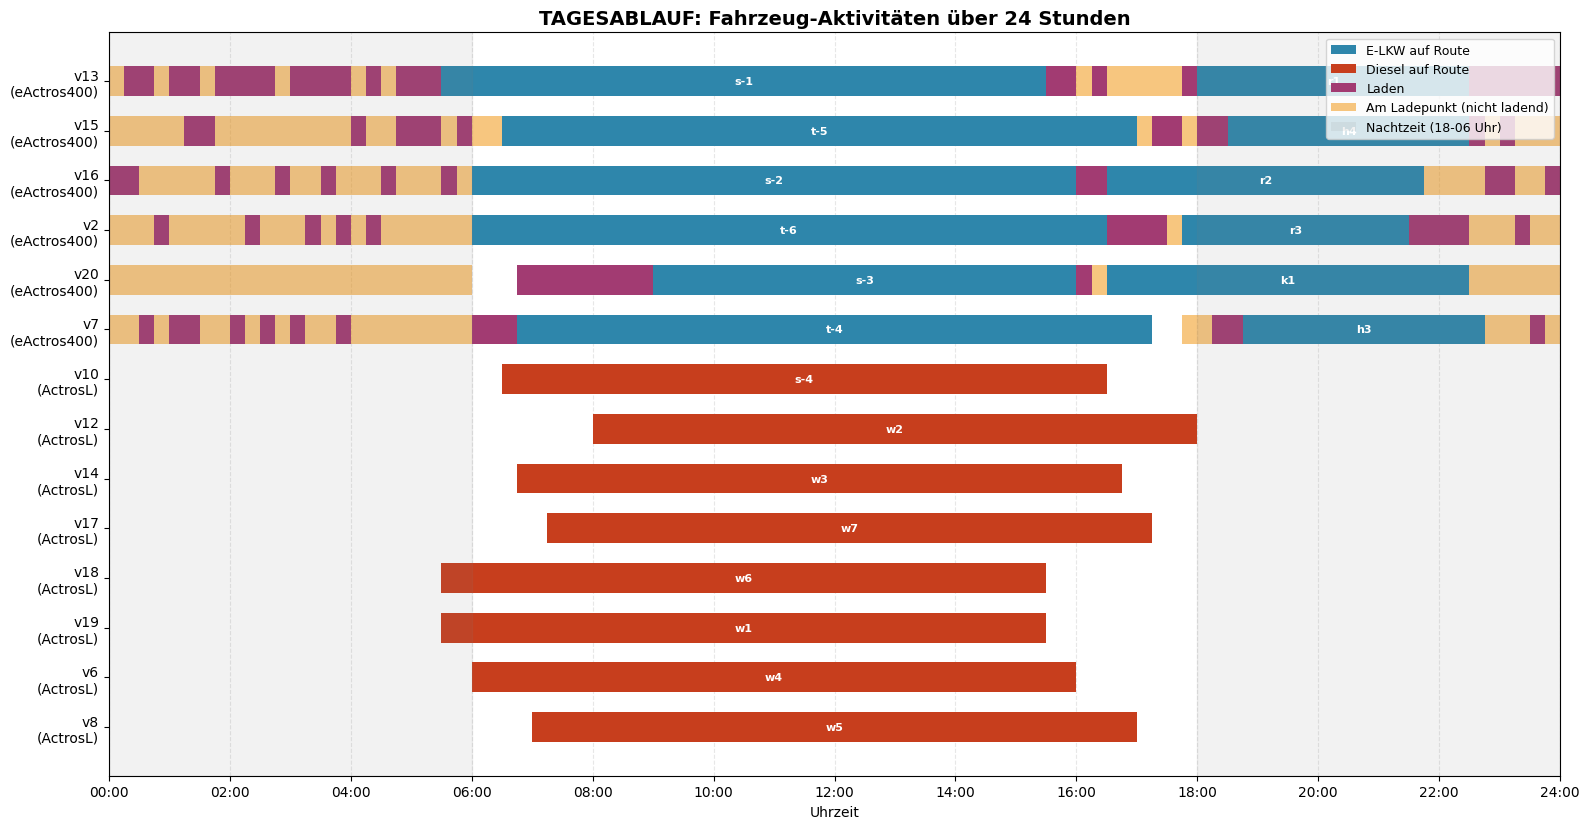


Legende:
  - Blau: E-LKW auf Route (mit Routenname)
  - Rot: Diesel-LKW auf Route
  - Magenta: Aktives Laden
  - Orange (transparent): Am Ladepunkt geparkt
  - Grauer Hintergrund: Nachtzeit (Parkpflicht für E-LKW)


In [35]:
# ============================================================================
# 8.2 GANTT-DIAGRAMM: TAGESABLAUF ALLER FAHRZEUGE
# ============================================================================

if status == 1:
    
    # Farben definieren
    COLOR_ROUTE = '#2E86AB'       # Blau für Routen
    COLOR_CHARGING = '#A23B72'    # Magenta für Laden
    COLOR_PARKED = '#F18F01'      # Orange für Parken
    COLOR_DIESEL = '#C73E1D'      # Rot für Diesel-Route
    
    # Aktive Fahrzeuge sammeln und sortieren
    active_vehicles = []
    for v in V:
        if value(use[v]) > 0.5:
            veh_type = None
            for f in F:
                if value(is_type[v, f]) > 0.5:
                    veh_type = f
                    break
            is_elec = veh_type in F_e
            active_vehicles.append((v, veh_type, is_elec))
    
    # Sortieren: E-LKW zuerst, dann nach ID
    active_vehicles.sort(key=lambda x: (not x[2], x[0]))
    
    # Plot erstellen
    fig, ax = plt.subplots(figsize=(16, max(6, len(active_vehicles) * 0.6)))
    
    y_pos = 0
    y_labels = []
    y_positions = []
    
    for v, veh_type, is_elec in active_vehicles:
        y_labels.append(f"{v}\n({veh_type})")
        y_positions.append(y_pos)
        
        # Für jeden Zeitschritt prüfen was das Fahrzeug macht
        for t in T:
            hour = (t - 1) * 0.25  # Stunde des Tages
            
            # Prüfe ob auf Route
            is_on_route_t = value(on_route[v, t]) > 0.5 if (v, t) in on_route else False
            
            # Prüfe ob ladend
            is_charging_t = any(value(charge[v, l, t]) > 0.1 for l in L)
            
            # Prüfe ob an Ladepunkt (aber nicht ladend)
            is_at_charger_t = any(value(w[v, l, t]) > 0.5 for l in L)
            
            # Balken zeichnen
            if is_on_route_t:
                color = COLOR_DIESEL if not is_elec else COLOR_ROUTE
                ax.barh(y_pos, 0.25, left=hour, height=0.6, color=color, edgecolor='none')
            elif is_charging_t:
                ax.barh(y_pos, 0.25, left=hour, height=0.6, color=COLOR_CHARGING, edgecolor='none')
            elif is_at_charger_t and is_elec:
                ax.barh(y_pos, 0.25, left=hour, height=0.6, color=COLOR_PARKED, edgecolor='none', alpha=0.5)
        
        # Routen-Labels hinzufügen
        routes_v = [(r, start_r[r], end_r[r]) for r in R if value(x[v, r]) > 0.5]
        for r, start_t, end_t in routes_v:
            start_hour = (start_t - 1) * 0.25
            duration = (end_t - start_t) * 0.25
            mid_hour = start_hour + duration / 2
            ax.text(mid_hour, y_pos, r, ha='center', va='center', fontsize=8, 
                   color='white', fontweight='bold')
        
        y_pos += 1
    
    # Achsen formatieren
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Uhrzeit')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 2))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 2)])
    ax.set_title('TAGESABLAUF: Fahrzeug-Aktivitäten über 24 Stunden', fontsize=14, fontweight='bold')
    
    # Nachtzeit markieren (18:00-06:00)
    ax.axvspan(0, 6, alpha=0.1, color='gray', label='Nachtzeit')
    ax.axvspan(18, 24, alpha=0.1, color='gray')
    
    # Legende
    legend_elements = [
        mpatches.Patch(facecolor=COLOR_ROUTE, label='E-LKW auf Route'),
        mpatches.Patch(facecolor=COLOR_DIESEL, label='Diesel auf Route'),
        mpatches.Patch(facecolor=COLOR_CHARGING, label='Laden'),
        mpatches.Patch(facecolor=COLOR_PARKED, alpha=0.5, label='Am Ladepunkt (nicht ladend)'),
        mpatches.Patch(facecolor='gray', alpha=0.1, label='Nachtzeit (18-06 Uhr)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # Grid
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Y-Achse invertieren (erstes Fahrzeug oben)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\nLegende:")
    print("  - Blau: E-LKW auf Route (mit Routenname)")
    print("  - Rot: Diesel-LKW auf Route")
    print("  - Magenta: Aktives Laden")
    print("  - Orange (transparent): Am Ladepunkt geparkt")
    print("  - Grauer Hintergrund: Nachtzeit (Parkpflicht für E-LKW)")

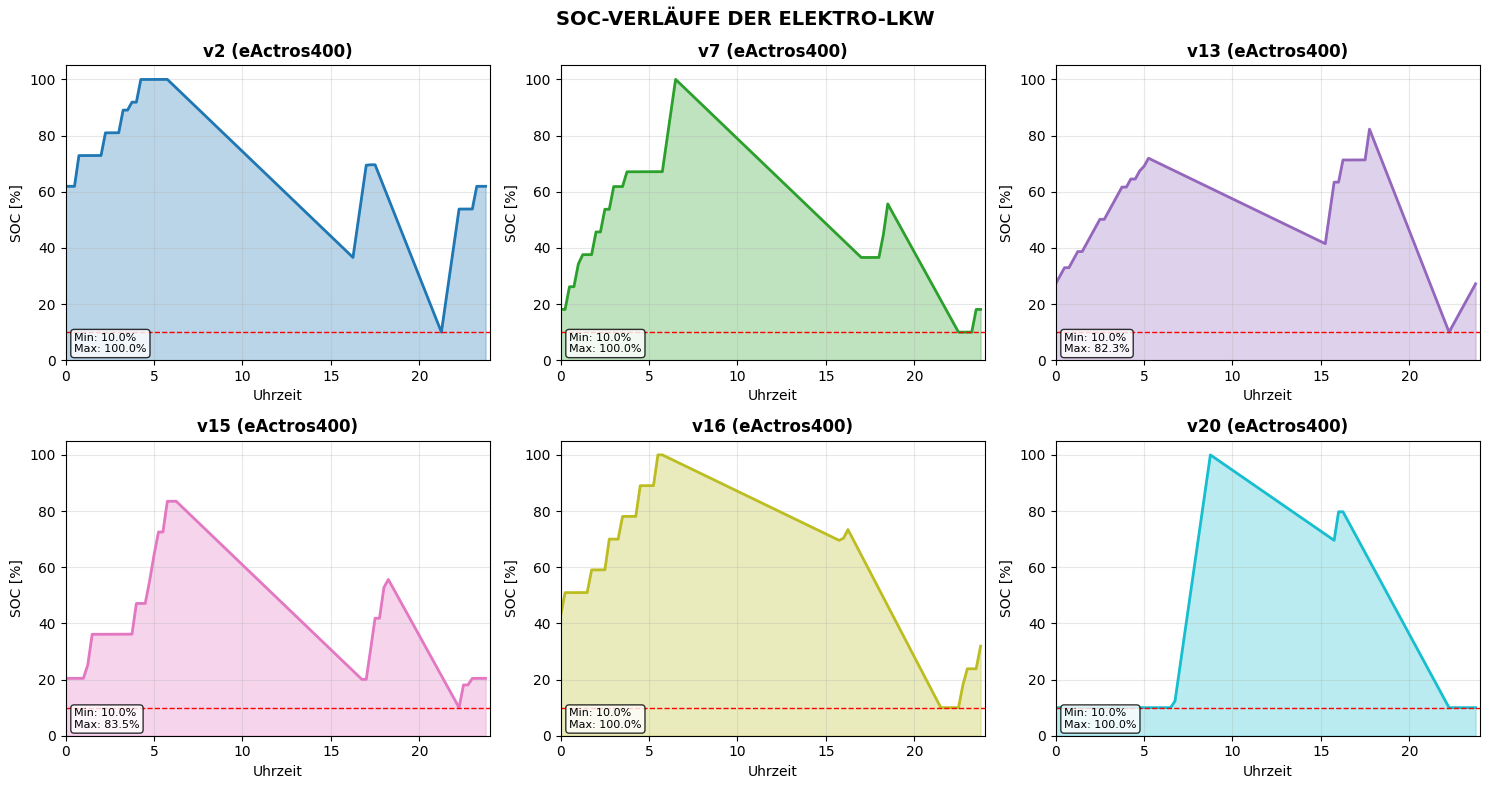


SOC-STATISTIK PRO E-LKW
Fahrzeug   Typ            Batterie    Min SOC    Max SOC
----------------------------------------------------------------------
v2         eActros400       414 kWh     10.0%    100.0%
v7         eActros400       414 kWh     10.0%    100.0%
v13        eActros400       414 kWh     10.0%     82.3%
v15        eActros400       414 kWh     10.0%     83.5%
v16        eActros400       414 kWh     10.0%    100.0%
v20        eActros400       414 kWh     10.0%    100.0%


In [36]:
# ============================================================================
# 8.3 SOC-VERLÄUFE DER E-LKW
# ============================================================================

if status == 1:
    
    # E-LKW sammeln
    electric_vehicles = []
    for v in V:
        if value(use[v]) > 0.5 and value(is_electric[v]) > 0.5:
            veh_type = None
            for f in F_e:
                if value(is_type[v, f]) > 0.5:
                    veh_type = f
                    break
            electric_vehicles.append((v, veh_type))
    
    if electric_vehicles:
        n_elec = len(electric_vehicles)
        n_cols = min(3, n_elec)
        n_rows = (n_elec + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
        colors = plt.cm.tab10(np.linspace(0, 1, n_elec))
        
        for idx, (v, veh_type) in enumerate(electric_vehicles):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            hours = [(t - 1) * 0.25 for t in T]
            soc_values = [value(soc[v, t]) for t in T]
            soc_percent = [s / battery_cap_f[veh_type] * 100 for s in soc_values]
            
            ax.plot(hours, soc_percent, color=colors[idx], linewidth=2)
            ax.fill_between(hours, soc_percent, alpha=0.3, color=colors[idx])
            ax.axhline(y=10, color='red', linestyle='--', linewidth=1)
            
            ax.set_xlim(0, 24)
            ax.set_ylim(0, 105)
            ax.set_xlabel('Uhrzeit')
            ax.set_ylabel('SOC [%]')
            ax.set_title(f'{v} ({veh_type})', fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            min_soc = min(soc_percent)
            max_soc = max(soc_percent)
            ax.text(0.02, 0.02, f'Min: {min_soc:.1f}%\nMax: {max_soc:.1f}%', 
                   transform=ax.transAxes, fontsize=8, verticalalignment='bottom',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        for idx in range(n_elec, n_rows * n_cols):
            axes[idx // n_cols, idx % n_cols].set_visible(False)
        
        plt.suptitle('SOC-VERLÄUFE DER ELEKTRO-LKW', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Tabelle
        print("\n" + "=" * 70)
        print("SOC-STATISTIK PRO E-LKW")
        print("=" * 70)
        print(f"{'Fahrzeug':<10} {'Typ':<12} {'Batterie':>10} {'Min SOC':>10} {'Max SOC':>10}")
        print("-" * 70)
        for v, veh_type in electric_vehicles:
            soc_values = [value(soc[v, t]) for t in T]
            min_pct = min(soc_values) / battery_cap_f[veh_type] * 100
            max_pct = max(soc_values) / battery_cap_f[veh_type] * 100
            print(f"{v:<10} {veh_type:<12} {battery_cap_f[veh_type]:>7} kWh {min_pct:>8.1f}% {max_pct:>8.1f}%")
    else:
        print("Keine E-LKW in der Flotte.")


In [37]:
# ============================================================================
# 8.5 DETAILLIERTE KOSTENANALYSE PRO FAHRZEUG
# ============================================================================

if status == 1:
    print("=" * 90)
    print("                         KOSTENANALYSE PRO FAHRZEUG")
    print("=" * 90)
    
    # Daten sammeln
    vehicle_costs = []
    
    for v in V:
        if value(use[v]) > 0.5:
            # Fahrzeugtyp ermitteln
            veh_type = None
            for f in F:
                if value(is_type[v, f]) > 0.5:
                    veh_type = f
                    break
            
            is_elec = veh_type in F_e
            
            # Routen und km
            routes_v = [r for r in R if value(x[v, r]) > 0.5]
            total_km = sum(dist_r[r] for r in routes_v)
            toll_km = sum(dist_toll_r[r] for r in routes_v)
            
            # CAPEX + OPEX + KFZ-Steuer
            capex = capex_f[veh_type]
            opex = opex_f[veh_type]
            kfz_tax = kfz_tax_f[veh_type]
            
            # THG-Quote (nur E-LKW)
            thg = thg_f[veh_type] if is_elec else 0
            
            # Kraftstoffkosten
            if is_elec:
                # Stromkosten: Berechne geladene kWh
                charged_kwh = sum(value(charge[v, l, t]) * delta_t for l in L for t in T)
                fuel_cost = charged_kwh * price_energy * days
                fuel_label = "Strom"
            else:
                # Dieselkosten
                consumption_l = (consumption_f[veh_type] / 100) * total_km
                fuel_cost = consumption_l * price_diesel * days
                fuel_label = "Diesel"
            
            # Mautkosten (nur Diesel)
            maut_cost = toll_km * price_toll * days if not is_elec else 0
            
            # Gesamtkosten pro Fahrzeug
            total_cost_v = capex + opex + kfz_tax + fuel_cost + maut_cost - thg
            
            vehicle_costs.append({
                'id': v,
                'type': veh_type,
                'is_electric': is_elec,
                'routes': routes_v,
                'km_day': total_km,
                'km_year': total_km * days,
                'capex': capex,
                'opex': opex,
                'kfz_tax': kfz_tax,
                'thg': thg,
                'fuel_cost': fuel_cost,
                'fuel_label': fuel_label,
                'maut': maut_cost,
                'total': total_cost_v
            })
    
    # Sortieren nach Gesamtkosten
    vehicle_costs.sort(key=lambda x: x['total'])
    
    # Tabelle ausgeben
    print(f"\n{'Fahrzeug':<8} {'Typ':<12} {'Routen':<12} {'km/Tag':>8} {'CAPEX':>10} {'OPEX':>8} {'Kraftstoff':>12} {'Maut':>10} {'THG':>8} {'GESAMT':>12}")
    print("-" * 110)
    
    total_all = 0
    for vc in vehicle_costs:
        routes_str = ",".join(vc['routes'][:2]) + ("..." if len(vc['routes']) > 2 else "")
        print(f"{vc['id']:<8} {vc['type']:<12} {routes_str:<12} {vc['km_day']:>8} {vc['capex']:>10,} {vc['opex']:>8,} {vc['fuel_cost']:>12,.0f} {vc['maut']:>10,.0f} {vc['thg']:>8,} {vc['total']:>12,.0f}")
        total_all += vc['total']
    
    print("-" * 110)
    print(f"{'SUMME':<8} {'':<12} {'':<12} {sum(vc['km_day'] for vc in vehicle_costs):>8} {sum(vc['capex'] for vc in vehicle_costs):>10,} {sum(vc['opex'] for vc in vehicle_costs):>8,} {sum(vc['fuel_cost'] for vc in vehicle_costs):>12,.0f} {sum(vc['maut'] for vc in vehicle_costs):>10,.0f} {sum(vc['thg'] for vc in vehicle_costs):>8,} {total_all:>12,.0f}")
    
    print(f"\nHinweis: Infrastruktur- und Netzkosten sind nicht pro Fahrzeug aufgeschluesselt.")

                         KOSTENANALYSE PRO FAHRZEUG

Fahrzeug Typ          Routen         km/Tag      CAPEX     OPEX   Kraftstoff       Maut      THG       GESAMT
--------------------------------------------------------------------------------------------------------------
v6       ActrosL      w4                100     24,000    6,000       10,816      2,829        0       44,201
v8       ActrosL      w5                100     24,000    6,000       10,816      2,829        0       44,201
v12      ActrosL      w2                100     24,000    6,000       10,816      2,829        0       44,201
v14      ActrosL      w3                100     24,000    6,000       10,816      2,829        0       44,201
v17      ActrosL      w7                100     24,000    6,000       10,816      2,829        0       44,201
v18      ActrosL      w6                100     24,000    6,000       10,816      2,829        0       44,201
v19      ActrosL      w1                100     24,000    6,000   

In [38]:
# ============================================================================
# 8.6 LADESTATISTIK PRO E-LKW
# ============================================================================

if status == 1:
    print("\n" + "=" * 90)
    print("                         LADESTATISTIK PRO E-LKW")
    print("=" * 90)
    
    # E-LKW sammeln
    electric_vehicles = []
    for v in V:
        if value(use[v]) > 0.5 and value(is_electric[v]) > 0.5:
            veh_type = None
            for f in F_e:
                if value(is_type[v, f]) > 0.5:
                    veh_type = f
                    break
            electric_vehicles.append((v, veh_type))
    
    if electric_vehicles:
        print(f"\n{'Fahrzeug':<10} {'Typ':<12} {'Batterie':>10} {'Geladen':>12} {'Ladezeit':>10} {'Genutzte Saeulen':<30}")
        print(f"{'':<10} {'':<12} {'[kWh]':>10} {'[kWh/Tag]':>12} {'[h/Tag]':>10} {'':<30}")
        print("-" * 100)
        
        total_charged = 0
        total_time = 0
        
        for v, veh_type in electric_vehicles:
            # Geladene kWh pro Tag
            charged_kwh = sum(value(charge[v, l, t]) * delta_t for l in L for t in T)
            total_charged += charged_kwh
            
            # Ladezeit in Stunden
            charging_hours = sum(1 for t in T if value(is_charging[v, t]) > 0.5) * delta_t
            total_time += charging_hours
            
            for t in T:
            
            # Genutzte Ladesaeulen
                used_chargers = []
                for l in L:
                    if any(value(w[v, l, t]) > 0.5 for t in T):
                        used_chargers.append(l)
            
            # Batteriekapazitaet
            battery_cap = battery_cap_f[veh_type]
            
            chargers_str = ", ".join(used_chargers) if used_chargers else "-"
            print(f"{v:<10} {veh_type:<12} {battery_cap:>10.0f} {charged_kwh:>12.1f} {charging_hours:>10.1f} {chargers_str:<30}")
        
        print("-" * 100)
        print(f"{'SUMME':<10} {'':<12} {'':<10} {total_charged:>12.1f} {total_time:>10.1f}")
        print(f"\nDurchschnitt pro E-LKW: {total_charged/len(electric_vehicles):.1f} kWh/Tag, {total_time/len(electric_vehicles):.1f} h Ladezeit/Tag")
    else:
        print("Keine E-LKW in der Flotte.")


                         LADESTATISTIK PRO E-LKW

Fahrzeug   Typ            Batterie      Geladen   Ladezeit Genutzte Saeulen              
                             [kWh]    [kWh/Tag]    [h/Tag]                               
----------------------------------------------------------------------------------------------------
v2         eActros400          414        536.1        9.0 Alpitronic-200, Alpitronic-400
v7         eActros400          414        475.3        8.0 Alpitronic-200                
v13        eActros400          414        447.6        9.2 Alpitronic-50, Alpitronic-400 
v15        eActros400          414        475.3        8.5 Alpitronic-200, Alpitronic-400
v16        eActros400          414        408.9        8.0 Alpitronic-200                
v20        eActros400          414        436.6        2.8 Alpitronic-50, Alpitronic-200 
----------------------------------------------------------------------------------------------------
SUMME                      

In [39]:
# ============================================================================
# 8.6b LADEVORGAENGE DETAILLIERT + REGELVERSTOSS-KONTROLLE
# ============================================================================

if status == 1:
    print("\n" + "=" * 90)
    print("                    LADEVORGAENGE PRO E-LKW (DETAILLIERT)")
    print("=" * 90)

    violations = []

    for v in V:
        if value(use[v]) > 0.5 and value(is_electric[v]) > 0.5:
            veh_type = next((f for f in F_e if value(is_type[v, f]) > 0.5), None)
            print(f"\n{v} ({veh_type}):")
            print("-" * 60)

            # Ladevorgaenge sammeln
            charging_events = []
            current_event = None

            for t in T:
                total_charge_t = sum(value(charge[v, l, t]) for l in L)
                current_charger = next((l for l in L if value(w[v, l, t]) > 0.5), None)

                if total_charge_t > 0.5:
                    if current_event is None:
                        current_event = {'start': t, 'charger': current_charger, 'kwh': 0}
                    current_event['end'] = t
                    current_event['kwh'] += total_charge_t * delta_t
                else:
                    if current_event is not None:
                        charging_events.append(current_event)
                        current_event = None

            if current_event is not None:
                charging_events.append(current_event)

            # Events ausgeben
            prev_charger = None
            prev_end = None
            for ev in charging_events:
                start_time = f"{(ev['start']-1)*15//60:02d}:{(ev['start']-1)*15%60:02d}"
                end_time = f"{ev['end']*15//60:02d}:{ev['end']*15%60:02d}"

                # Route dazwischen?
                route_between = False
                if prev_end is not None:
                    for t in range(prev_end + 1, ev['start']):
                        if value(on_route[v, t]) > 0.5:
                            route_between = True
                            break

                suffix = ""
                if prev_charger and prev_charger != ev['charger']:
                    if route_between:
                        suffix = " (nach Route)"
                    else:
                        suffix = " *** WECHSEL OHNE ROUTE! ***"
                        violations.append((v, start_time, prev_charger, ev['charger']))

                print(f"  {start_time}-{end_time}  {ev['charger']:<18} {ev['kwh']:>6.1f} kWh{suffix}")
                prev_charger = ev['charger']
                prev_end = ev['end']

    print("\n" + "=" * 90)
    if violations:
        print("*** REGELVERSTOESSE GEFUNDEN ***")
        for v, time, old, new in violations:
            print(f"  {v}: Wechsel um {time} von {old} -> {new} OHNE Route!")
    else:
        print("OK: Keine Regelverstoesse - Alle Saeulenwechsel nach Routen")


                    LADEVORGAENGE PRO E-LKW (DETAILLIERT)

v2 (eActros400):
------------------------------------------------------------
  00:45-01:00  Alpitronic-400       47.7 kWh
  02:15-02:30  Alpitronic-400       35.2 kWh
  03:15-03:30  Alpitronic-400       35.2 kWh
  03:45-04:00  Alpitronic-400       12.3 kWh
  04:15-04:30  Alpitronic-400       35.2 kWh
  16:30-17:30  Alpitronic-200      143.8 kWh (nach Route)
  21:30-22:30  Alpitronic-400      191.0 kWh (nach Route)
  23:15-23:30  Alpitronic-400       35.2 kWh

v7 (eActros400):
------------------------------------------------------------
  00:30-00:45  Alpitronic-200       35.2 kWh
  01:00-01:30  Alpitronic-200       49.7 kWh
  02:00-02:15  Alpitronic-200       35.2 kWh
  02:30-02:45  Alpitronic-200       35.2 kWh
  03:00-03:15  Alpitronic-200       35.2 kWh
  03:45-04:00  Alpitronic-200       22.9 kWh
  06:00-06:45  Alpitronic-200      143.2 kWh
  18:15-18:45  Alpitronic-200       83.0 kWh
  23:30-23:45  Alpitronic-200       3


                         KOSTENAUFSCHLUESSELUNG GESAMT

Kostenposition               Betrag [EUR/Jahr]     Anteil
------------------------------------------------------------
LKW CAPEX                           492,000.00      53.3%
LKW OPEX                             78,000.00       8.4%
KFZ-Steuer                            4,448.00       0.5%
Ladeinfrastruktur                    33,500.00       3.6%
Strom (Arbeit)                      180,682.89      19.6%
Strom (Leistung)                     28,650.32       3.1%
Strom (Grund)                         1,000.00       0.1%
Diesel                               88,691.20       9.6%
Maut                                 22,630.40       2.5%
THG-Quote (Erloes)                   -6,000.00      -0.6%
------------------------------------------------------------
GESAMTKOSTEN                        923,602.81     100.0%


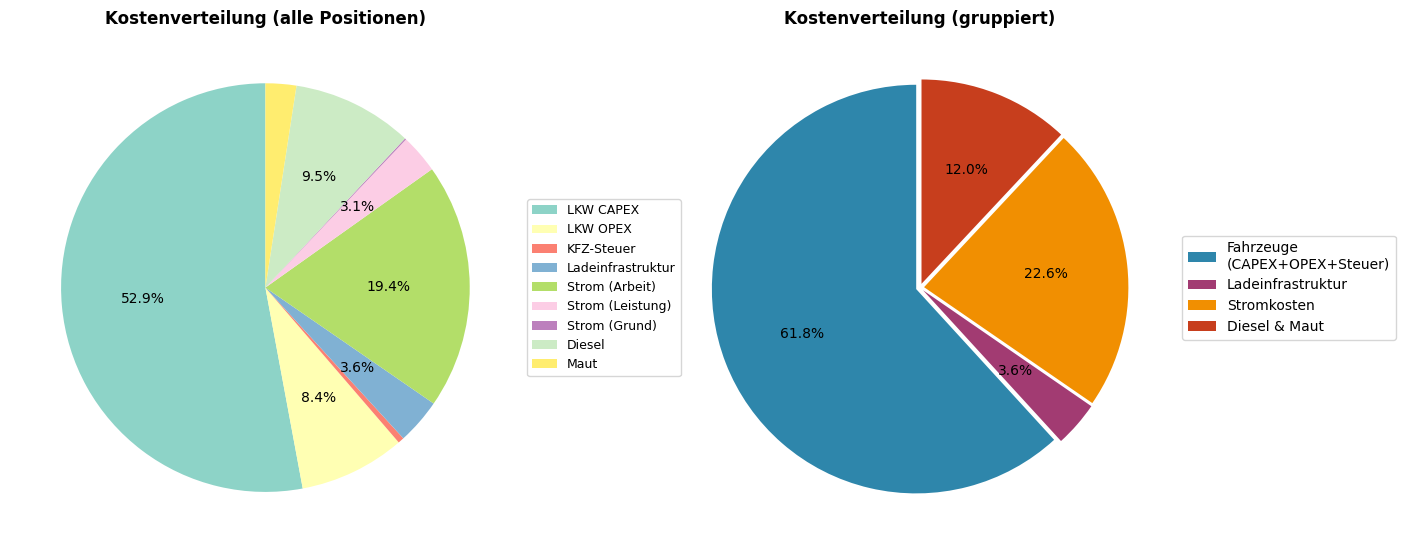


* THG-Quote: 6,000.00 EUR Erloese (reduziert Gesamtkosten)


In [40]:
# ============================================================================
# 8.7 KOSTENAUFSCHLUESSELUNG GESAMT (TORTENDIAGRAMM)
# ============================================================================

if status == 1:
    print("\n" + "=" * 90)
    print("                         KOSTENAUFSCHLUESSELUNG GESAMT")
    print("=" * 90)
    
    # Einzelne Kostenkomponenten berechnen
    
    # 1. LKW-Kosten (CAPEX + OPEX + KFZ-Steuer)
    cost_lkw_capex = sum(capex_f[f] * value(is_type[v, f]) for v in V for f in F)
    cost_lkw_opex = sum(opex_f[f] * value(is_type[v, f]) for v in V for f in F)
    cost_lkw_tax = sum(kfz_tax_f[f] * value(is_type[v, f]) for v in V for f in F)
    
    # 2. THG-Quote (Erloese, negativ)
    cost_thg = -sum(thg_f[f] * value(is_type[v, f]) for v in V for f in F_e)
    
    # 3. Ladeinfrastruktur
    cost_charger_capex = sum(capex_l[l] * value(y[l]) for l in L)
    cost_charger_opex = sum(opex_l[l] * value(y[l]) for l in L)
    
    # 4. Stromkosten
    daily_energy = sum(value(p_grid[t]) * delta_t for t in T)
    cost_strom_arbeit = price_energy * days * daily_energy
    cost_strom_leistung = price_power * value(P_peak)
    cost_strom_grund = price_base
    
    # 5. Netzanschluss-Erweiterung
    cost_netz = price_grid_extension * value(extend_grid)
    
    # 6. Batteriespeicher
    cost_speicher = (1 + storage_opex_rate) * (price_storage_power * value(P_storage) + price_storage_cap * value(E_storage))
    
    # 7. Dieselkosten
    cost_diesel = days * price_diesel * sum(
        (consumption_f['ActrosL'] / 100) * dist_r[r] * value(diesel_route[v, r])
        for v in V for r in R
    )
    
    # 8. Mautkosten
    cost_maut = days * price_toll * sum(
        dist_toll_r[r] * value(diesel_route[v, r])
        for v in V for r in R
    )
    
    # Zusammenfassung
    costs = {
        'LKW CAPEX': cost_lkw_capex,
        'LKW OPEX': cost_lkw_opex,
        'KFZ-Steuer': cost_lkw_tax,
        'Ladeinfrastruktur': cost_charger_capex + cost_charger_opex,
        'Strom (Arbeit)': cost_strom_arbeit,
        'Strom (Leistung)': cost_strom_leistung,
        'Strom (Grund)': cost_strom_grund,
        'Netzanschluss': cost_netz,
        'Batteriespeicher': cost_speicher,
        'Diesel': cost_diesel,
        'Maut': cost_maut,
        'THG-Quote (Erloes)': cost_thg,
    }
    
    # Tabelle
    print(f"\n{'Kostenposition':<25} {'Betrag [EUR/Jahr]':>20} {'Anteil':>10}")
    print("-" * 60)
    
    total = sum(costs.values())
    for name, val in costs.items():
        if val != 0:
            anteil = val / total * 100 if total > 0 else 0
            print(f"{name:<25} {val:>20,.2f} {anteil:>9.1f}%")
    
    print("-" * 60)
    print(f"{'GESAMTKOSTEN':<25} {total:>20,.2f} {100.0:>9.1f}%")
    
    # Tortendiagramm
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Nur positive Kosten fuer Tortendiagramm (THG ist Erloes)
    costs_positive = {k: v for k, v in costs.items() if v > 0}
    
    # Farben
    colors = plt.cm.Set3(np.linspace(0, 1, len(costs_positive)))
    
    # Tortendiagramm 1: Alle Kosten
    wedges, texts, autotexts = ax1.pie(
        costs_positive.values(), 
        labels=None,
        autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '',
        colors=colors,
        startangle=90
    )
    ax1.set_title('Kostenverteilung (alle Positionen)', fontweight='bold')
    ax1.legend(wedges, costs_positive.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    
    # Tortendiagramm 2: Gruppierte Kosten
    grouped_costs = {
        'Fahrzeuge\n(CAPEX+OPEX+Steuer)': cost_lkw_capex + cost_lkw_opex + cost_lkw_tax,
        'Ladeinfrastruktur': cost_charger_capex + cost_charger_opex,
        'Stromkosten': cost_strom_arbeit + cost_strom_leistung + cost_strom_grund,
        'Netz & Speicher': cost_netz + cost_speicher,
        'Diesel & Maut': cost_diesel + cost_maut,
    }
    grouped_costs = {k: v for k, v in grouped_costs.items() if v > 0}
    
    colors2 = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6B4226']
    wedges2, texts2, autotexts2 = ax2.pie(
        grouped_costs.values(),
        labels=None,
        autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '',
        colors=colors2[:len(grouped_costs)],
        startangle=90,
        explode=[0.02] * len(grouped_costs)
    )
    ax2.set_title('Kostenverteilung (gruppiert)', fontweight='bold')
    ax2.legend(wedges2, grouped_costs.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # THG-Quote Hinweis
    if cost_thg < 0:
        print(f"\n* THG-Quote: {-cost_thg:,.2f} EUR Erloese (reduziert Gesamtkosten)")


                         VERGLEICH DIESEL VS. ELEKTRO

Kennzahl                            Diesel               Elektro              Differenz           
-----------------------------------------------------------------------------------------------
Anzahl Fahrzeuge                    8                    6                    -                   
Gefahrene km/Jahr                           213,200         653,900 -                   
Gesamtkosten [EUR/Jahr]                     355,770         504,683        +148,913
Kosten pro km [EUR/km]                        1.669           0.772          -0.897
Kraftstoff/Strom [EUR/Jahr]                  88,691         180,683         +91,992
Mautkosten [EUR/Jahr]                        22,630               0         -22,630
THG-Quote Erloese [EUR/Jahr]                      0           6,000          +6,000
CO2-Emissionen [t/Jahr]                       146.3           289.1          +142.8


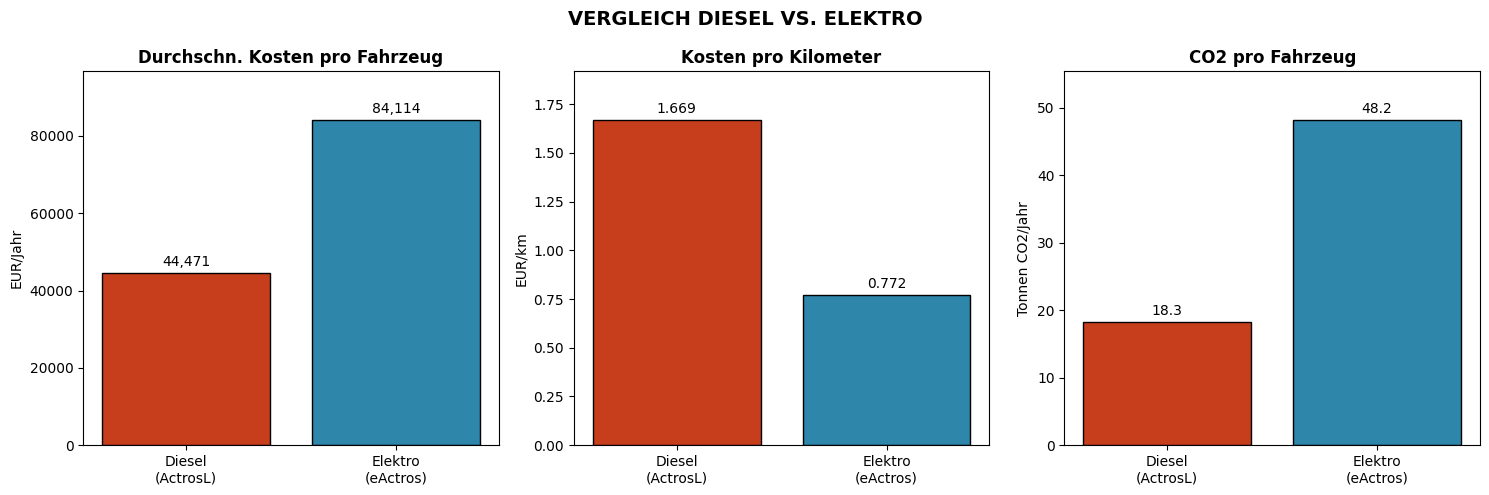


------------------------------------------------------------
FAZIT:
  Elektro ist 53.7% guenstiger pro km als Diesel
  CO2-Ersparnis durch E-LKW: -142.8 Tonnen/Jahr
  (Annahme: Strommix mit 400g CO2/kWh)


In [41]:
# ============================================================================
# 8.8 VERGLEICH DIESEL VS. ELEKTRO
# ============================================================================

if status == 1:
    print("\n" + "=" * 90)
    print("                         VERGLEICH DIESEL VS. ELEKTRO")
    print("=" * 90)
    
    # Diesel-Fahrzeuge
    diesel_vehicles = [vc for vc in vehicle_costs if not vc['is_electric']]
    # Elektro-Fahrzeuge
    electric_vehicles_data = [vc for vc in vehicle_costs if vc['is_electric']]
    
    if diesel_vehicles and electric_vehicles_data:
        # Aggregierte Werte Diesel
        diesel_count = len(diesel_vehicles)
        diesel_km_year = sum(vc['km_year'] for vc in diesel_vehicles)
        diesel_total_cost = sum(vc['total'] for vc in diesel_vehicles)
        diesel_fuel_cost = sum(vc['fuel_cost'] for vc in diesel_vehicles)
        diesel_maut_cost = sum(vc['maut'] for vc in diesel_vehicles)
        
        # Aggregierte Werte Elektro
        electric_count = len(electric_vehicles_data)
        electric_km_year = sum(vc['km_year'] for vc in electric_vehicles_data)
        electric_total_cost = sum(vc['total'] for vc in electric_vehicles_data)
        electric_fuel_cost = sum(vc['fuel_cost'] for vc in electric_vehicles_data)
        electric_thg = sum(vc['thg'] for vc in electric_vehicles_data)
        
        # Kosten pro km
        diesel_cost_per_km = diesel_total_cost / diesel_km_year if diesel_km_year > 0 else 0
        electric_cost_per_km = electric_total_cost / electric_km_year if electric_km_year > 0 else 0
        
        # CO2-Emissionen (Diesel: ca. 2.64 kg CO2/L, E-LKW: 0 direkt, aber Strom-Mix)
        co2_per_liter = 2.64  # kg CO2 pro Liter Diesel
        diesel_consumption_year = sum((consumption_f['ActrosL'] / 100) * vc['km_year'] for vc in diesel_vehicles)
        diesel_co2 = diesel_consumption_year * co2_per_liter / 1000  # Tonnen
        
        # Strom-CO2 (Annahme: 400g CO2/kWh fuer deutschen Strommix, oder 0 bei Oekostrom)
        co2_per_kwh = 0.4  # kg CO2 pro kWh (Strommix)
        electric_consumption_year = sum(value(charge[v, l, t]) * delta_t for v in V for l in L for t in T if value(is_electric[v]) > 0.5) * days
        electric_co2 = electric_consumption_year * co2_per_kwh / 1000  # Tonnen
        
        # Tabelle
        print(f"\n{'Kennzahl':<35} {'Diesel':<20} {'Elektro':<20} {'Differenz':<20}")
        print("-" * 95)
        print(f"{'Anzahl Fahrzeuge':<35} {diesel_count:<20} {electric_count:<20} {'-':<20}")
        print(f"{'Gefahrene km/Jahr':<35} {diesel_km_year:>15,.0f} {electric_km_year:>15,.0f} {'-':<20}")
        print(f"{'Gesamtkosten [EUR/Jahr]':<35} {diesel_total_cost:>15,.0f} {electric_total_cost:>15,.0f} {electric_total_cost - diesel_total_cost:>+15,.0f}")
        print(f"{'Kosten pro km [EUR/km]':<35} {diesel_cost_per_km:>15.3f} {electric_cost_per_km:>15.3f} {electric_cost_per_km - diesel_cost_per_km:>+15.3f}")
        print(f"{'Kraftstoff/Strom [EUR/Jahr]':<35} {diesel_fuel_cost:>15,.0f} {electric_fuel_cost:>15,.0f} {electric_fuel_cost - diesel_fuel_cost:>+15,.0f}")
        print(f"{'Mautkosten [EUR/Jahr]':<35} {diesel_maut_cost:>15,.0f} {'0':>15} {-diesel_maut_cost:>+15,.0f}")
        print(f"{'THG-Quote Erloese [EUR/Jahr]':<35} {'0':>15} {electric_thg:>15,.0f} {electric_thg:>+15,.0f}")
        print(f"{'CO2-Emissionen [t/Jahr]':<35} {diesel_co2:>15.1f} {electric_co2:>15.1f} {electric_co2 - diesel_co2:>+15.1f}")
        
        # Balkendiagramm Vergleich
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. Gesamtkosten pro Fahrzeug
        ax1 = axes[0]
        avg_diesel = diesel_total_cost / diesel_count
        avg_electric = electric_total_cost / electric_count
        bars1 = ax1.bar(['Diesel\n(ActrosL)', 'Elektro\n(eActros)'], [avg_diesel, avg_electric], 
                       color=['#C73E1D', '#2E86AB'], edgecolor='black')
        ax1.set_ylabel('EUR/Jahr')
        ax1.set_title('Durchschn. Kosten pro Fahrzeug', fontweight='bold')
        ax1.bar_label(bars1, fmt='{:,.0f}', padding=3)
        ax1.set_ylim(0, max(avg_diesel, avg_electric) * 1.15)
        
        # 2. Kosten pro km
        ax2 = axes[1]
        bars2 = ax2.bar(['Diesel\n(ActrosL)', 'Elektro\n(eActros)'], [diesel_cost_per_km, electric_cost_per_km], 
                       color=['#C73E1D', '#2E86AB'], edgecolor='black')
        ax2.set_ylabel('EUR/km')
        ax2.set_title('Kosten pro Kilometer', fontweight='bold')
        ax2.bar_label(bars2, fmt='{:.3f}', padding=3)
        ax2.set_ylim(0, max(diesel_cost_per_km, electric_cost_per_km) * 1.15)
        
        # 3. CO2-Emissionen pro Fahrzeug
        ax3 = axes[2]
        co2_diesel_per_veh = diesel_co2 / diesel_count
        co2_electric_per_veh = electric_co2 / electric_count
        bars3 = ax3.bar(['Diesel\n(ActrosL)', 'Elektro\n(eActros)'], [co2_diesel_per_veh, co2_electric_per_veh], 
                       color=['#C73E1D', '#2E86AB'], edgecolor='black')
        ax3.set_ylabel('Tonnen CO2/Jahr')
        ax3.set_title('CO2 pro Fahrzeug', fontweight='bold')
        ax3.bar_label(bars3, fmt='{:.1f}', padding=3)
        ax3.set_ylim(0, max(co2_diesel_per_veh, co2_electric_per_veh) * 1.15)
        
        plt.suptitle('VERGLEICH DIESEL VS. ELEKTRO', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Fazit
        print("\n" + "-" * 60)
        print("FAZIT:")
        if electric_cost_per_km < diesel_cost_per_km:
            ersparnis_pct = (1 - electric_cost_per_km / diesel_cost_per_km) * 100
            print(f"  Elektro ist {ersparnis_pct:.1f}% guenstiger pro km als Diesel")
        else:
            mehrkosten_pct = (electric_cost_per_km / diesel_cost_per_km - 1) * 100
            print(f"  Elektro ist {mehrkosten_pct:.1f}% teurer pro km als Diesel")
        
        co2_ersparnis = diesel_co2 - electric_co2
        print(f"  CO2-Ersparnis durch E-LKW: {co2_ersparnis:.1f} Tonnen/Jahr")
        print(f"  (Annahme: Strommix mit {co2_per_kwh*1000:.0f}g CO2/kWh)")
        
    elif electric_vehicles_data:
        print("\nReine Elektro-Flotte - kein Vergleich moeglich.")
    else:
        print("\nReine Diesel-Flotte - kein Vergleich moeglich.")

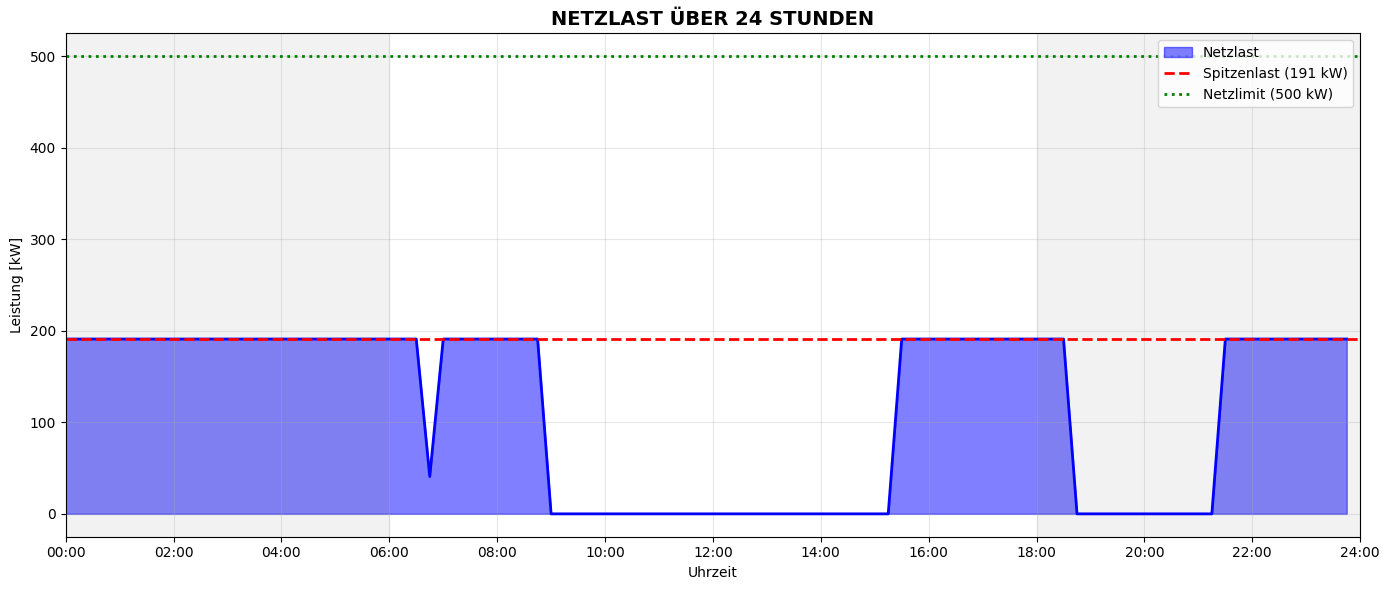


STROMKOSTEN-ZUSAMMENFASSUNG
Täglicher Energiebedarf:      2779.7 kWh
Jährlicher Energiebedarf:   722731.6 kWh
Spitzenlast:                   191.0 kW
--------------------------------------------------
Arbeitspreis (0.25 €/kWh): 180,682.89 €
Leistungspreis (150 €/kW):  28,650.32 €
Grundgebühr:                1,000.00 €
--------------------------------------------------
STROMKOSTEN GESAMT:       210,333.21 €/Jahr


In [42]:
# ============================================================================
# 8.4 LADEPLAN UND NETZLAST
# ============================================================================

if status == 1:
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    hours = [(t - 1) * 0.25 for t in T]
    grid_power = [value(p_grid[t]) for t in T]
    peak_val = value(P_peak)
    
    ax.fill_between(hours, grid_power, alpha=0.5, color='blue', label='Netzlast')
    ax.plot(hours, grid_power, 'b-', linewidth=2)
    ax.axhline(y=peak_val, color='red', linestyle='--', linewidth=2, label=f'Spitzenlast ({peak_val:.0f} kW)')
    
    # Netzlimit
    grid_limit = P_grid_max_base + (500 if value(extend_grid) > 0.5 else 0)
    ax.axhline(y=grid_limit, color='green', linestyle=':', linewidth=2, label=f'Netzlimit ({grid_limit} kW)')
    
    ax.set_xlim(0, 24)
    ax.set_xlabel('Uhrzeit')
    ax.set_ylabel('Leistung [kW]')
    ax.set_title('NETZLAST ÜBER 24 STUNDEN', fontsize=14, fontweight='bold')
    ax.set_xticks(range(0, 25, 2))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 2)])
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Nachtzeit markieren
    ax.axvspan(0, 6, alpha=0.1, color='gray')
    ax.axvspan(18, 24, alpha=0.1, color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Stromkosten-Zusammenfassung
    daily_energy = sum(value(p_grid[t]) * delta_t for t in T)
    yearly_energy = daily_energy * days
    energy_cost = yearly_energy * price_energy
    power_cost = peak_val * price_power
    
    print("\n" + "=" * 50)
    print("STROMKOSTEN-ZUSAMMENFASSUNG")
    print("=" * 50)
    print(f"Täglicher Energiebedarf:  {daily_energy:>10.1f} kWh")
    print(f"Jährlicher Energiebedarf: {yearly_energy:>10.1f} kWh")
    print(f"Spitzenlast:              {peak_val:>10.1f} kW")
    print("-" * 50)
    print(f"Arbeitspreis ({price_energy} €/kWh): {energy_cost:>10,.2f} €")
    print(f"Leistungspreis ({price_power} €/kW): {power_cost:>10,.2f} €")
    print(f"Grundgebühr:              {price_base:>10,.2f} €")
    print("-" * 50)
    print(f"STROMKOSTEN GESAMT:       {energy_cost + power_cost + price_base:>10,.2f} €/Jahr")
